In [1]:
import numpy as np
import scipy.stats as stats

In [2]:
def TSVtoList(tsvFile):
    import csv
    #Create a container for the tsv
    tsvList = []
    #Open the .tsv file and append it to a python list
    with open(tsvFile,'rb') as tsvIn:
        tsvIn = csv.reader(tsvIn, delimiter='\t')
        for row in tsvIn:
            tsvList.append(row)
    return tsvList

In [3]:
def ExcludeNonImageRows(tsvList):
    index = []
    currentIndex = 1
    mediaNameIndex = GetIndexForHeader("MediaName")
    for row in tsvList[1:]:
        if row[mediaNameIndex] == "":
            index.append(currentIndex)
        currentIndex += 1
    for row in reversed(index):
        del tsvList[row]
    return tsvList[1:]

In [4]:
def ExcludeNonAOIRows(tsvList):
    saveRow = False
    returnList = []
    for row in tsvList:
        #print row[GetIndexForHeader("FixationIndex")], row[GetIndexForHeader("SaccadeIndex")]
        FixationIndexIndex = GetIndexForHeader("FixationIndex")
        AOIHeader = GetIndexForHeader("AOI[AOI]Hit")
        questionNumber = row[GetIndexForHeader("MediaName")]
        aORb = questionNumber[2]
        questionNumber = int(questionNumber[-6:-4])
        if aORb == "A":
            AOIHeader = AOIHeader + (2*(questionNumber-1))
        elif aORb == "B":
            AOIHeader = AOIHeader + (24*2) +(2*(questionNumber-1))
            
        if row[AOIHeader] == "1":
            saveRow = True
        if row[FixationIndexIndex] != "" and row[AOIHeader] == "0":
            saveRow = False
            
        if saveRow is True:
            returnList.append(row) 
    return returnList

In [5]:
def DivideIntoSeparateImageLists(tsvList):
    imageDictionary = {}
    mediaNameIndex = GetIndexForHeader("MediaName")
    for row in tsvList[1:]:
        if row[113] not in imageDictionary:
            imageDictionary[row[mediaNameIndex]] = [row]
        else:
            imageDictionary[row[mediaNameIndex]].append(row)
    return imageDictionary

In [6]:
def CalculateDurationForImage(dataList):
    RecordingTimestampIndex = GetIndexForHeader("RecordingTimestamp")
    start =  float(dataList[0][RecordingTimestampIndex])
    end = float(dataList[-1][RecordingTimestampIndex])
    duration = end - start
    #Convert to seconds
    duration = duration / 1000
    return duration

In [7]:
def CalculateAmountOfFixations(dataList):
    #index = 0
    FixationIndexIndex = GetIndexForHeader("FixationIndex")
    #for row in dataList:
        #if dataList[index][FixationIndexIndex] is not "":
            #break
        #index += 1
    #start = int(dataList[index][FixationIndexIndex])
    #index = -1
    #for row in reversed(dataList):
        #if dataList[index][FixationIndexIndex] is not "":
            #break
        #index -= 1
    #end = int(dataList[index][FixationIndexIndex])
    #amount = end - start
    
    amountList = []
    
    for row in dataList:
        if row[FixationIndexIndex] not in amountList:
            amountList.append(row[FixationIndexIndex])
    amount = len(amountList)
    return amount

In [8]:
def CalculateFixationPrecision(dataList):
    notedFixations = []
    count = 0
    FixationIndexIndex = GetIndexForHeader("FixationIndex")
    AOIHeader = GetIndexForHeader("AOI[Polygon]Hit")
    questionNumber = dataList[1][GetIndexForHeader("MediaName")]
    aORb = questionNumber[2]
    questionNumber = int(questionNumber[-6:-4])
    if aORb == "A":
        AOIHeader = AOIHeader + (2*(questionNumber-1))
    elif aORb == "B":
        AOIHeader = AOIHeader + (24*2) +(2*(questionNumber-1))
    for row in dataList:
        if row[AOIHeader] == "1":
            if row[FixationIndexIndex] not in notedFixations:
                notedFixations.append(row[FixationIndexIndex])
                count += 1
    return count

In [9]:
def CalculateFixationDuration(dataList):
    index = 0
    FixationIndexIndex = GetIndexForHeader("FixationIndex")
    RecordingTimestampIndex = GetIndexForHeader("RecordingTimestamp")
    prev = "0"
    current = "0"
    start = 0
    end = 0
    fixationDurations = []
    for row in dataList:
        prev = current
        current = row[FixationIndexIndex]
        #print row[FixationIndexIndex], row[GetIndexForHeader("SaccadeIndex")]
        if prev is "" and current is not "":
            start = row[RecordingTimestampIndex]
        elif prev is not "" and current is "":
            end = row[RecordingTimestampIndex]
            duration = int(end) - int(start)
            duration = float(duration) / 1000
            fixationDurations.append(duration)
    return fixationDurations

In [10]:
def CalculateAmountOfFixationsPerSecond(duration, amountOfFixations):
    duration = float(duration)
    amountOfFixations = float(amountOfFixations)
    fixationsPerSecond = amountOfFixations/duration
    return fixationsPerSecond

In [11]:
def CalculateAmountOfSaccades(dataList):
    #saccadeList = []
    SaccadeIndexIndex = GetIndexForHeader("SaccadeIndex")
    #for row in dataList:
        #if row[145] is not "":
            #saccadeList.append(row[SaccadeIndexIndex])
    #start = int(min(saccadeList))
    #end = int(max(saccadeList))
    #amountOfSaccades = end - start
    
    amountList = []
    
    for row in dataList:
        if row[SaccadeIndexIndex] not in amountList:
            amountList.append(row[SaccadeIndexIndex])
    
    amountOfSaccades = len(amountList)
    
    return amountOfSaccades

In [12]:
def CalculateDurationOfSaccades(dataList):
    saccadeDurationList = []
    tempSaccadeDurationList = []
    RecordingTimestampIndex = GetIndexForHeader("RecordingTimestamp")
    SaccadeIndexIndex = GetIndexForHeader("SaccadeIndex")
    for row in dataList:
        if row[SaccadeIndexIndex] is not "":
            tempSaccadeDurationList.append(int(row[RecordingTimestampIndex]))
        else:
            if len(tempSaccadeDurationList) is not 0:
                saccadeStart = tempSaccadeDurationList[0]
                saccadeEnd = tempSaccadeDurationList[-1]
                saccadeDuration = saccadeEnd - saccadeStart
                saccadeDurationList.append(saccadeDuration)
                tempSaccadeDurationList = []
    if len(tempSaccadeDurationList) is not 0:
        sacadeStart = tempSaccadeDurationList[0]
        saccadeEnd = tempSaccadeDurationList[-1]
        saccadeDuration = saccadeEnd - saccadeStart
        saccadeDurationList.append(saccadeDuration)
        
    return saccadeDurationList

In [13]:
def CalculateVelocityOfSaccades(dataList):
    listOfVelocities = []
    startIndex = 0
    SaccadicAmplitudeIndex = GetIndexForHeader("SaccadicAmplitude")
    if dataList[0][SaccadicAmplitudeIndex] is not "":
        for row in dataList:
            if row[SaccadicAmplitudeIndex] is "":
                break
            else:
                startIndex += 1
    previous = ""
    current = ""
    for row in dataList[startIndex:]:
        previous = current
        current = row[SaccadicAmplitudeIndex]
        if previous is "" and current is not "":
            #convert number because it uses comma and needs to use punctuation
            number = float(row[SaccadicAmplitudeIndex].replace(',','.'))
            listOfVelocities.append(number)
    return listOfVelocities

In [14]:
def CalculatePupilDilation(dataList):
    pupilLeft = []
    pupilRight = []
    PupilLeftIndex = GetIndexForHeader("PupilLeft")
    for row in dataList:
        print row
        pupilLeft.append(float(row[PupilLeftIndex].replace(',','.')))
        pupilRight.append(float(row[PupilLeftIndex + 1].replace(',','.')))
    return pupilLeft, pupilRight

In [15]:
def GetIndexForHeader(name):
    indexForHeader = dataHeaders.index(name)
    return indexForHeader

In [16]:
def CalculateAccuracy(dataList):
    print dataList[0]

In [17]:
filePath = "C:/Users/Simon/Documents/Skole/Master/participants/processed/p764b@pupil@study_data_processed.tsv"

dataList = TSVtoList(filePath)

dataHeaders = dataList[0]

dataList = ExcludeNonImageRows(dataList)

dataDictionary = DivideIntoSeparateImageLists(dataList)

print(dataDictionary.keys())

IOError: [Errno 2] No such file or directory: 'C:/Users/Simon/Documents/Skole/Master/participants/processed/p764b@pupil@study_data_processed.tsv'

In [18]:
index = 0
for header in dataHeaders:
    print str(index) + ": " + header
    index += 1 

NameError: name 'dataHeaders' is not defined

In [19]:
duration = CalculateDurationForImage(dataDictionary["M4A-Q24.png"])
print duration

NameError: name 'dataDictionary' is not defined

In [20]:
amountOfFixations = CalculateAmountOfFixations(dataDictionary["M4A-Q24.png"])
print amountOfFixations

NameError: name 'dataDictionary' is not defined

In [21]:
fixationDuration = CalculateFixationDuration(dataDictionary["M4A-Q24.png"])
print np.mean(fixationDuration)

NameError: name 'dataDictionary' is not defined

In [22]:
fixationsPerSecond = CalculateAmountOfFixationsPerSecond(duration, amountOfFixations)
print fixationsPerSecond

NameError: name 'duration' is not defined

In [23]:
amountOfSaccades = CalculateAmountOfSaccades(dataDictionary["M4A-Q24.png"])
print amountOfSaccades

NameError: name 'dataDictionary' is not defined

In [24]:
saccadeDurationList = CalculateDurationOfSaccades(dataDictionary["M4A-Q24.png"])
print np.mean(saccadeDurationList)

NameError: name 'dataDictionary' is not defined

In [25]:
strTest = "M1A-Q01.png"
print strTest[-6:-4]

01


In [26]:
saccadeVelocityList = CalculateVelocityOfSaccades(dataDictionary["M4A-Q24.png"])
print np.mean(saccadeVelocityList)

NameError: name 'dataDictionary' is not defined

In [27]:
import numpy as np
pupilDilationLeftList, pupilDilationRightList = CalculatePupilDilation(dataDictionary["M4A-Q24.png"])
print np.mean(pupilDilationLeftList), np.var(pupilDilationLeftList), np.std(pupilDilationLeftList)
print np.mean(pupilDilationRightList), np.var(pupilDilationRightList), np.std(pupilDilationRightList)

NameError: name 'dataDictionary' is not defined

In [28]:
import os

#Variables to hold the data
data = {}
dataHeaders = []

filePath = "C:/Users/Simon/Documents/Skole/Master/participants/processed/"
filePath = "C:/Users/Simon/Downloads/xxx/"

#filePath = "/Users/SMC/Documents/Skole/MasterThesis/finaltest/"

#fileList = os.listdir(filePath)
#fileList = fileList[1:]

for participant in os.listdir(filePath):
    #participantshort = participant[:5]
    
    newPath = filePath + participant
    
    dataList = TSVtoList(newPath)

    dataHeaders = dataList[0]
    
    participantshort = dataList[1][GetIndexForHeader("ParticipantName")]
    print participantshort, participant

    dataListExcluded = ExcludeNonImageRows(dataList)
    print len(dataListExcluded)
    dataListExcluded = ExcludeNonAOIRows(dataListExcluded)
    print len(dataListExcluded)
    dataList = dataList[1:]

    dataDictionary = DivideIntoSeparateImageLists(dataListExcluded)
    
    aORb = participantshort[-1]
    dataList = dataList[-1]
    
    answerKey = {"M1X-Q01":"True",
                "M1X-Q02":"True",
                "M1X-Q03":"True",
                "M1X-Q04":"False",
                "M1X-Q05":"False",
                "M1X-Q06":"False",
                "M2X-Q07":"False",
                "M2X-Q08":"True",
                "M2X-Q09":"True",
                "M2X-Q10":"False",
                "M2X-Q11":"False",
                "M2X-Q12":"False",
                "M3X-Q13":"True",
                "M3X-Q14":"False",
                "M3X-Q15":"True",
                "M3X-Q16":"False",
                "M3X-Q17":"True",
                "M3X-Q18":"False",
                "M4X-Q19":"True",
                "M4X-Q20":"False",
                "M4X-Q21":"True",
                "M4X-Q22":"False",
                "M4X-Q23":"True",
                "M4X-Q24":"False"}
    
    for image in dataDictionary:
        if image not in data:
            data[image] = {}
            data[image]["duration"] = []
            data[image]["accuracy"] = []
            data[image]["amountOfFixations"] = []
            data[image]["fixationDuration"] = []
            data[image]["fixationsPerSecond"] = []
            data[image]["amountOfSaccades"] = []
            data[image]["saccadeDurationList"] = []
            data[image]["saccadeVelocityList"] = []
            data[image]["pupilDilationLeftList"] = []
            data[image]["pupilDilationRightList"] = []
            data[image]["pupilDilationMean"] = []
            data[image]["fixationPrecision"] = []
        duration = CalculateDurationForImage(dataDictionary[image])
        data[image]["duration"].append(duration)
        amountOfFixations = CalculateAmountOfFixations(dataDictionary[image])
        data[image]["amountOfFixations"].append(amountOfFixations)
        fixationDuration = CalculateFixationDuration(dataDictionary[image])
        data[image]["fixationDuration"].append(np.mean(fixationDuration))
        fixationsPerSecond = CalculateAmountOfFixationsPerSecond(duration, amountOfFixations)
        data[image]["fixationsPerSecond"].append(fixationsPerSecond)
        amountOfSaccades = CalculateAmountOfSaccades(dataDictionary[image])
        data[image]["amountOfSaccades"].append(amountOfSaccades)
        #saccadeDurationList = CalculateDurationOfSaccades(dataDictionary[image])
        #data[image]["saccadeDurationList"].append(saccadeDurationList)
        saccadeVelocityList = CalculateVelocityOfSaccades(dataDictionary[image])
        data[image]["saccadeVelocityList"].append(np.mean(saccadeVelocityList))
        #pupilDilationLeftList, pupilDilationRightList = CalculatePupilDilation(dataDictionary[image])
        #data[image]["pupilDilationLeftList"].append(np.std(pupilDilationLeftList))
        #data[image]["pupilDilationRightList"].append(np.std(pupilDilationRightList))
        #data[image]["pupilDilationMean"].append(np.mean([np.std(pupilDilationLeftList),np.std(pupilDilationRightList)]))
        fixationPrecision = CalculateFixationPrecision(dataDictionary[image])
        #print fixationPrecision, amountOfFixations, image
        try:
            fixationPrecision = float(fixationPrecision) / float(amountOfFixations) * 100
            data[image]["fixationPrecision"].append(fixationPrecision)
        except:
            print "Devision by zero"
        
        imageShort = image[:-4]
        if imageShort[0] != "T":
            answer = dataList[GetIndexForHeader("["+imageShort+"]Value")]
            if answer[0] == " ":
                answer = answer[1:]
            pre = imageShort[:2]
            post = imageShort[-4:]
            if answerKey[pre+"X"+post] == answer:
                data[image]["accuracy"].append(1)
            else:
                data[image]["accuracy"].append(0)


p665a p665a.tsv
195789
129138
p786a pilot test A_Rec 02.tsv
263727
189164
p024a pilot test A_Rec 03.tsv
189448
117773
p551a pilot test A_Rec 04.tsv
228009
175424
p057a pilot test A_Rec 05.tsv
235470
150788
p846a pilot test A_Rec 06.tsv
232937
176538
p876a pilot test A_Rec 07.tsv
243874
187988
p335b pilot test B_p335b.tsv
150095
104375
p465 pilot test B_p465b.tsv
158666
109597
p847b pilot test B_Rec 01.tsv
163474
117347
p741b pilot test B_Rec 03.tsv
119719
87482
p338b pilot test B_Rec 04.tsv
161954
97067
p768b pilot test B_Rec 05.tsv
202555
145065


In [29]:
data["M4A-Q24.png"]

{'accuracy': [1, 1, 1, 1, 0, 1, 0],
 'amountOfFixations': [35, 50, 57, 32, 92, 50, 57],
 'amountOfSaccades': [35, 67, 60, 44, 197, 56, 64],
 'duration': [18.379, 27.641, 34.395, 20.537, 43.841, 26.973, 30.899],
 'fixationDuration': [25.465176470588236,
  21.663145833333335,
  15.10588888888889,
  30.446290322580648,
  11.389786516853931,
  20.133458333333333,
  18.264454545454548],
 'fixationPrecision': [80.0,
  80.0,
  85.96491228070175,
  71.875,
  32.608695652173914,
  30.0,
  68.42105263157895],
 'fixationsPerSecond': [1.9043473529571793,
  1.8089070583553417,
  1.6572176188399474,
  1.5581633149924528,
  2.0984922789169955,
  1.8537055574092611,
  1.8447198938476972],
 'pupilDilationLeftList': [],
 'pupilDilationMean': [],
 'pupilDilationRightList': [],
 'saccadeDurationList': [],
 'saccadeVelocityList': [3.5333333333333332,
  4.0685416666666665,
  3.8327777777777783,
  3.1933333333333342,
  5.1885393258426973,
  3.6083333333333329,
  3.8456363636363635]}

In [30]:
index = 0
for row in dataHeaders:
    print index, row, dataDictionary["M1B-Q01.png"][1][index]
    index += 1

0 ﻿ExportDate 16-06-2017
1 StudioVersionRec 3.4.5
2 StudioProjectName pilot test 1
3 StudioTestName pilot test B
4 ParticipantName p768b
5 [M1BE-Q1]Value  Very high mental effort
6 [M1BE-Q2]Value  Neither high nor low mental effort
7 [M1BE-Q3]Value  High mental effort
8 [M1BE-Q4]Value  High mental effort
9 [M1BE-Q5]Value  High mental effort
10 [M1BE-Q6]Value  Neither high nor low mental effort
11 [M1B-Q01]Value True
12 [M1B-Q02]Value True
13 [M1B-Q03]Value True
14 [M1B-Q04]Value  False
15 [M1B-Q05]Value  False
16 [M1B-Q06]Value  False
17 [M2BE-Q10]Value  Neither high nor low mental effort
18 [M2BE-Q11]Value  Low mental effort
19 [M2BE-Q12]Value  Neither high nor low mental effort
20 [M2BE-Q7]Value  Low mental effort
21 [M2BE-Q8]Value  Low mental effort
22 [M2BE-Q9]Value  Very low mental effort
23 [M2B-Q07]Value  False
24 [M2B-Q08]Value True
25 [M2B-Q09]Value True
26 [M2B-Q10]Value  False
27 [M2B-Q11]Value True
28 [M2B-Q12]Value  False
29 [M3BE-Q13]Value  Neither high nor low mental eff

In [31]:
GetIndexForHeader("AOI[AOI]Hit")

153

In [32]:
for row in dataDictionary["M1A-Q01.png"]:
    print row[GetIndexForHeader("FixationIndex")], row[GetIndexForHeader("SaccadeIndex")], row[GetIndexForHeader("AOI[AOI]Hit")]

KeyError: 'M1A-Q01.png'

In [33]:
measure = "pupilDilationMean"
TUT = data["TUTX-Q01.png"][measure] + data["TUTX-Q02.png"][measure] + data["TUTX-Q03.png"][measure]
tutMean = np.mean(TUT)

for image in data.keys():
    data[image]["pupilDilationDiff"] = []
    for index in xrange(len(data[image]["pupilDilationMean"])):
        data[image]["pupilDilationDiff"].append(float(data[image]["pupilDilationMean"][index])-float(TUT[index]))

KeyError: 'TUTX-Q01.png'

In [34]:
from pylab import *
import matplotlib.pyplot as plt
print data['M2B-Q11.png']["fixationPrecision"]

[43.333333333333336, 28.57142857142857, 14.516129032258066, 54.54545454545454, 42.42424242424242, 72.0]


In [35]:
def getModelData(model, measure, localAndGlobal="Both"):
    multiplier = int(model[1])
    aORb = model[2]
    end = 6 * multiplier
    start = end - 5
    if localAndGlobal is "Local":
        end = end - 3
    elif localAndGlobal is "Global":
        start = start + 3
    prefix = model +"-"
    questions = []
    for index in range(start, end+1):
        question = index
        question = "%02d" % (question,)
        question = "Q"+question
        questions.append(question)
    
    collecter = []
    for question in questions:
        collecter += data[prefix+question+".png"][measure]
    
    return collecter

print getModelData("M1A", "duration")
%matplotlib inline

[12.424, 11.288, 12.402, 27.54, 26.959, 17.056, 20.801, 23.53, 17.685, 13.302, 31.432, 21.615, 23.568, 66.829, 31.229, 31.118, 15.67, 18.279, 37.39, 13.887, 18.285, 33.111, 51.548, 33.891, 47.069, 64.504, 29.666, 48.576, 38.481, 47.214, 41.395, 35.805, 40.542, 35.813, 28.774, 18.547, 47.003, 48.491, 28.191, 43.362, 49.03, 16.509]


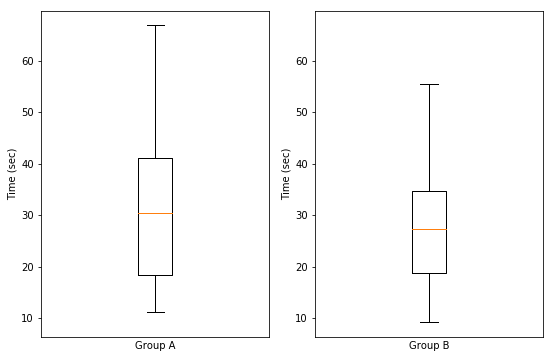

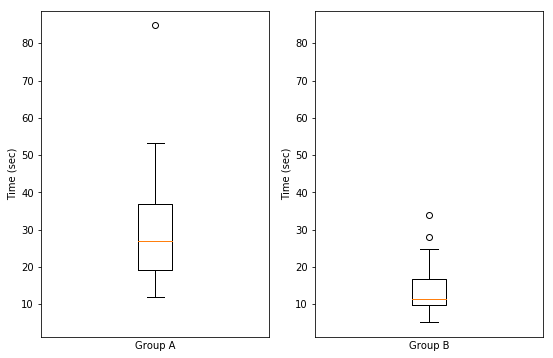

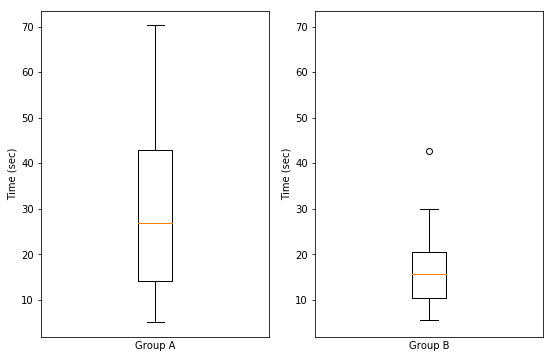

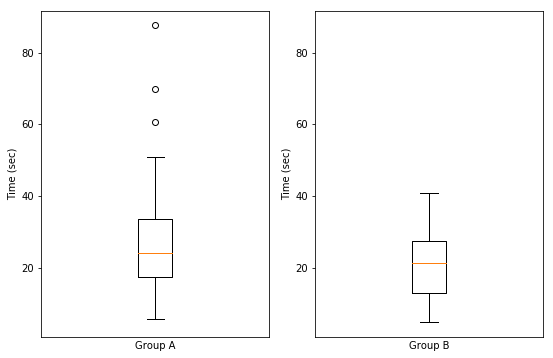

In [36]:
%matplotlib inline
measure = "duration"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]





def boxplot(figureSubtitle, ylabel, MA, MB):
    fig = plt.figure(figsize=(9,6))
    #fig.suptitle(figureSubtitle, fontsize=14, fontweight='bold')

    ax1A = fig.add_subplot(121)
    ax1A.set_ylabel(ylabel)
    ax1A.set_xlabel("Group A")
    ax1A.tick_params(axis="x", which="both", bottom="off", top="off", labelbottom="off")
    bp1A = ax1A.boxplot(MA)

    ax1B = fig.add_subplot(122, sharey = ax1A)
    ax1B.set_ylabel(ylabel)
    ax1B.set_xlabel("Group B")
    ax1B.tick_params(axis="x", which="both", bottom="off", top="off", labelbottom="off")
    bp1B = ax1B.boxplot(MB)
    
    return fig
db = "DurationBoxplot"    
m1 = boxplot("Model 1 duration", "Time (sec)", M1A, M1B)
m1.savefig("M1"+db)
m2 = boxplot("Model 2 duration", "Time (sec)", M2A, M2B)
m2.savefig("M2"+db)
m3 = boxplot("Model 3 duration", "Time (sec)", M3A, M3B)
m3.savefig("M3"+db)
m4 = boxplot("Model 4 duration", "Time (sec)", M4A, M4B)
m4.savefig("M4"+db)

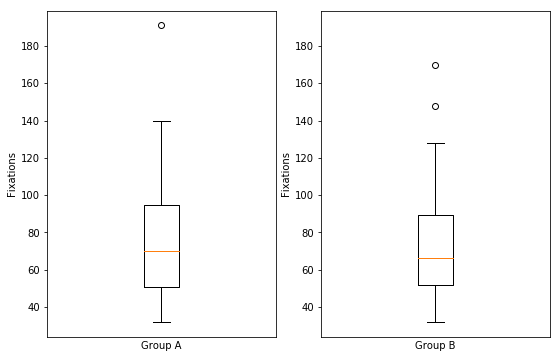

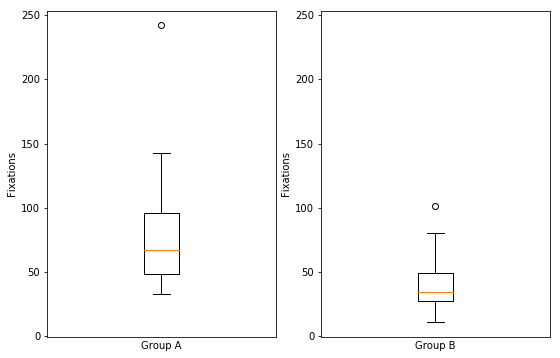

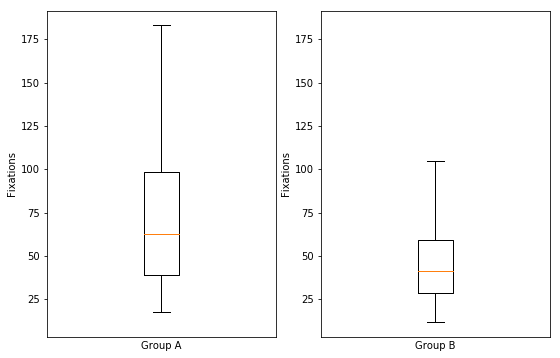

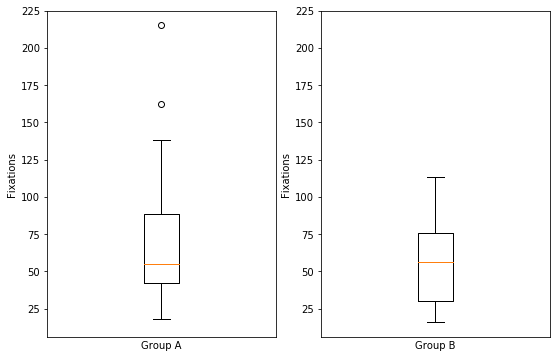

In [37]:
measure = "amountOfFixations"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]


db = "amountOfFixationsBoxplot"    
m1 = boxplot("Model 1 fixation amount", "Fixations", M1A, M1B)
m1.savefig("M1"+db)
m2 = boxplot("Model 2 fixation amount", "Fixations", M2A, M2B)
m2.savefig("M2"+db)
m3 = boxplot("Model 3 fixation amount", "Fixations", M3A, M3B)
m3.savefig("M3"+db)
m4 = boxplot("Model 4 fixation amount", "Fixations", M4A, M4B)
m4.savefig("M4"+db)

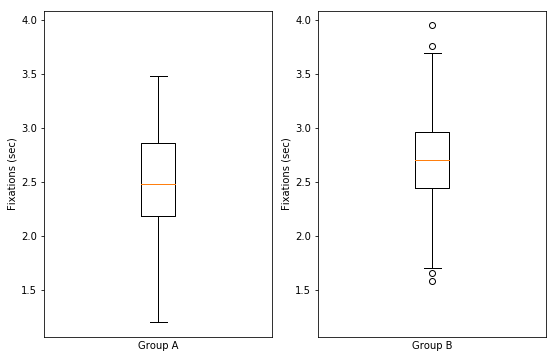

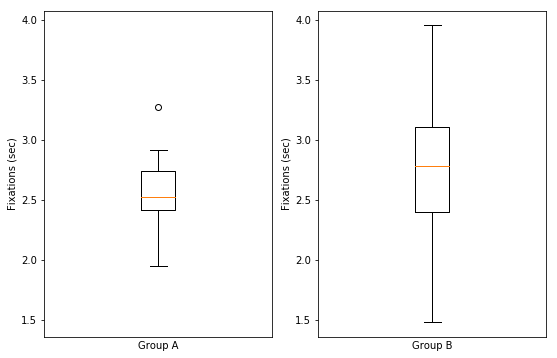

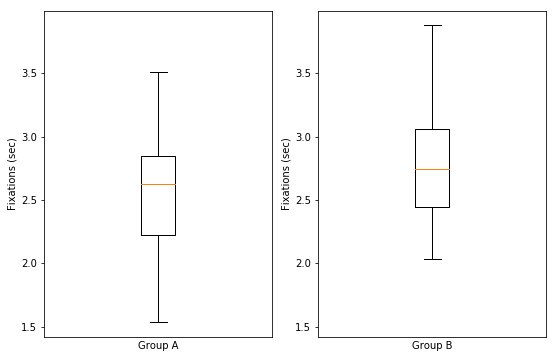

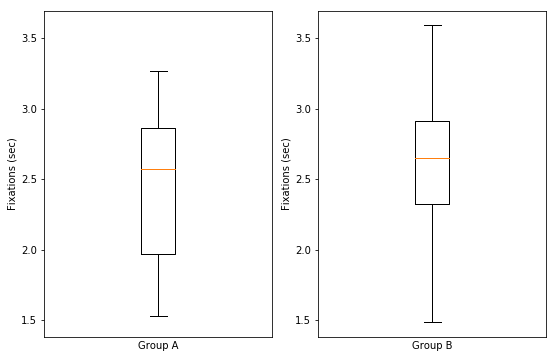

In [38]:
measure = "fixationsPerSecond"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]


db = "fixationsPerSecondBoxplot"    
m1 = boxplot("Model 1 fixations per second", "Fixations (sec)", M1A, M1B)
m1.savefig("M1"+db)
m2 = boxplot("Model 2 fixations per second", "Fixations (sec)", M2A, M2B)
m2.savefig("M2"+db)
m3 = boxplot("Model 3 fixations per second", "Fixations (sec)", M3A, M3B)
m3.savefig("M3"+db)
m4 = boxplot("Model 4 fixations per second", "Fixations (sec)", M4A, M4B)
m4.savefig("M4"+db)

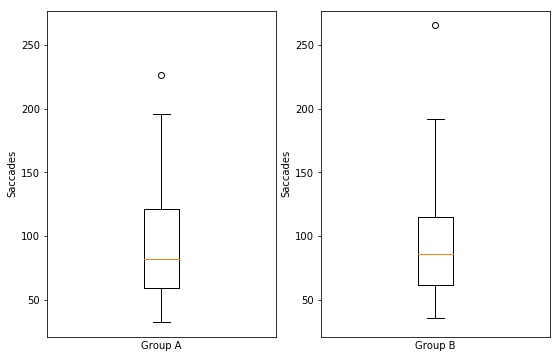

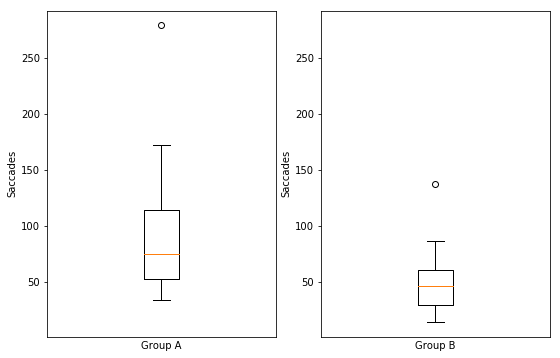

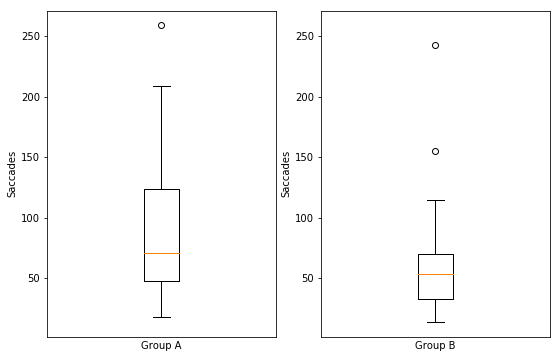

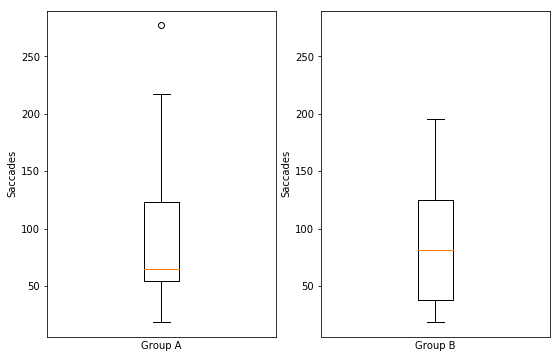

In [39]:
measure = "amountOfSaccades"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]


db = "amountOfSaccadesBoxplot"    
m1 = boxplot("Model 1 amount of saccades", "Saccades", M1A, M1B)
m1.savefig("M1"+db)
m2 = boxplot("Model 2 amount of saccades", "Saccades", M2A, M2B)
m2.savefig("M2"+db)
m3 = boxplot("Model 3 amount of saccades", "Saccades", M3A, M3B)
m3.savefig("M3"+db)
m4 = boxplot("Model 4 amount of saccades", "Saccades", M4A, M4B)
m4.savefig("M4"+db)

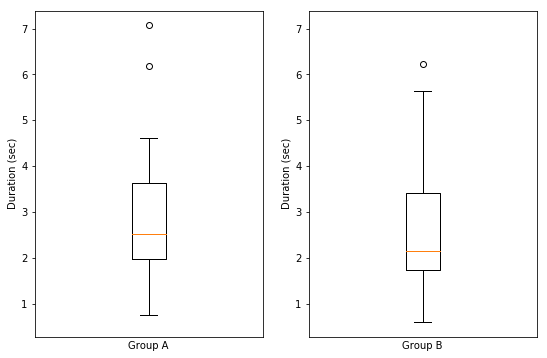

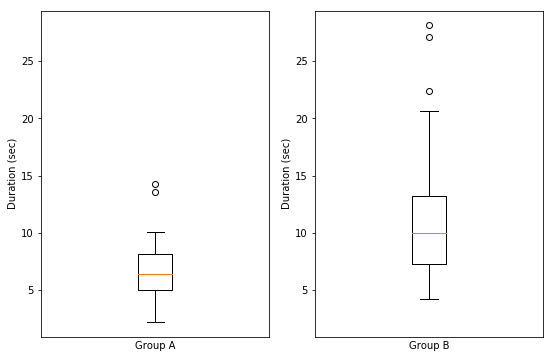

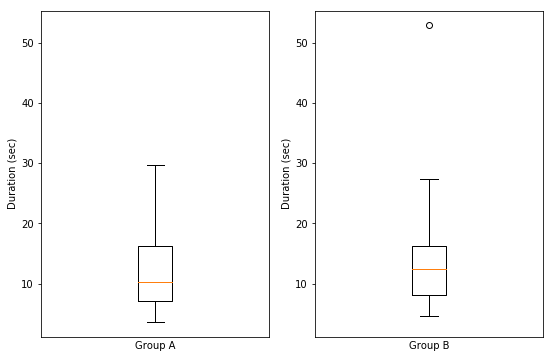

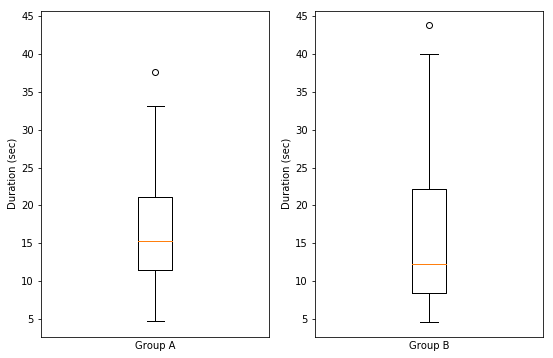

In [40]:
measure = "fixationDuration"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]


db = "fixationDurationBoxplot"    
m1 = boxplot("Model 1 fixation duration", "Duration (sec)", M1A, M1B)
m1.savefig("M1"+db)
m2 = boxplot("Model 2 fixation duration", "Duration (sec)", M2A, M2B)
m2.savefig("M2"+db)
m3 = boxplot("Model 3 fixation duration", "Duration (sec)", M3A, M3B)
m3.savefig("M3"+db)
m4 = boxplot("Model 4 fixation duration", "Duration (sec)", M4A, M4B)
m4.savefig("M4"+db)

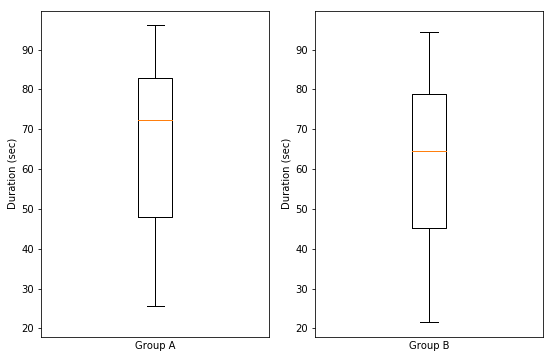

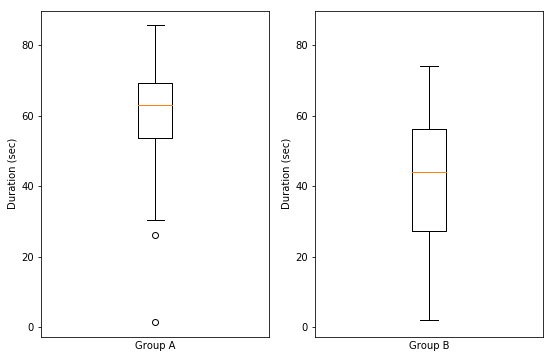

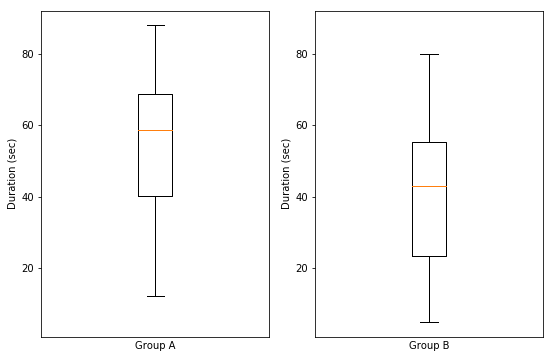

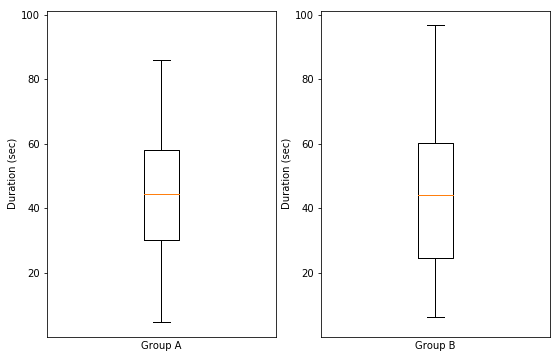

In [43]:
measure = "fixationPrecision"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]


db = "fixationDurationBoxplot"    
m1 = boxplot("Model 1 fixation duration", "Duration (sec)", M1A, M1B)
m1.savefig("M1"+db)
m2 = boxplot("Model 2 fixation duration", "Duration (sec)", M2A, M2B)
m2.savefig("M2"+db)
m3 = boxplot("Model 3 fixation duration", "Duration (sec)", M3A, M3B)
m3.savefig("M3"+db)
m4 = boxplot("Model 4 fixation duration", "Duration (sec)", M4A, M4B)
m4.savefig("M4"+db)

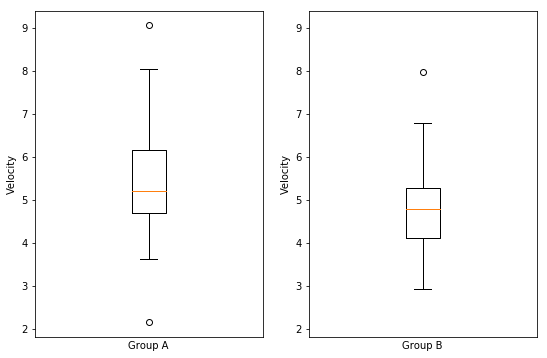

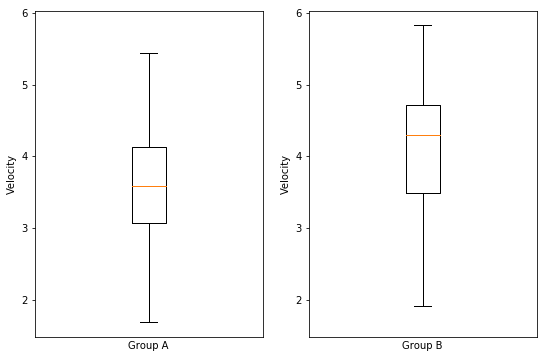

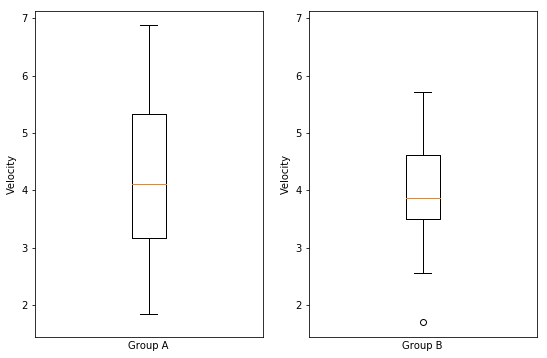

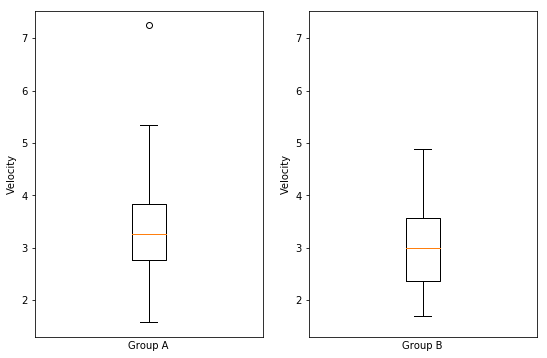

In [41]:
measure = "saccadeVelocityList"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]


db = "saccadeVelocityBoxplot"    
m1 = boxplot("Model 1 saccade velocity", "Velocity", M1A, M1B)
m1.savefig("M1"+db)
m2 = boxplot("Model 2 saccade velocity", "Velocity", M2A, M2B)
m2.savefig("M2"+db)
m3 = boxplot("Model 3 saccade velocity", "Velocity", M3A, M3B)
m3.savefig("M3"+db)
m4 = boxplot("Model 4 saccade velocity", "Velocity", M4A, M4B)
m4.savefig("M4"+db)

IndexError: list index out of range

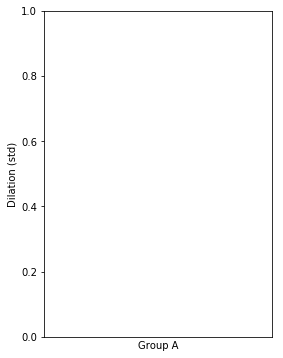

In [42]:
measure = "pupilDilationLeftList"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]


db = "pupilDilationLeftListBoxplot"    
m1 = boxplot("Model 1 pupil dilation (left eye)", "Dilation (std)", M1A, M1B)
m1.savefig("M1"+db)
m2 = boxplot("Model 2 pupil dilation (left eye)", "Dilation (std)", M2A, M2B)
m2.savefig("M2"+db)
m3 = boxplot("Model 3 pupil dilation (left eye)", "Dilation (std)", M3A, M3B)
m3.savefig("M3"+db)
m4 = boxplot("Model 4 pupil dilation (left eye)", "Dilation (std)", M4A, M4B)
m4.savefig("M4"+db)

In [ ]:
measure = "pupilDilationRightList"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]


db = "pupilDilationRightListBoxplot"    
m1 = boxplot("Model 1 pupil dilation (right eye)", "Dilation (std)", M1A, M1B)
m1.savefig("M1"+db)
m2 = boxplot("Model 2 pupil dilation (right eye)", "Dilation (std)", M2A, M2B)
m2.savefig("M2"+db)
m3 = boxplot("Model 3 pupil dilation (right eye)", "Dilation (std)", M3A, M3B)
m3.savefig("M3"+db)
m4 = boxplot("Model 4 pupil dilation (right eye)", "Dilation (std)", M4A, M4B)
m4.savefig("M4"+db)

In [ ]:
measure = "pupilDilationMean"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]


db = "pupilDilationMeanBoxplot"    
m1 = boxplot("Model 1 pupil dilation", "Dilation (std)", M1A, M1B)
m1.savefig("M1"+db)
m2 = boxplot("Model 2 pupil dilation", "Dilation (std)", M2A, M2B)
m2.savefig("M2"+db)
m3 = boxplot("Model 3 pupil dilation", "Dilation (std)", M3A, M3B)
m3.savefig("M3"+db)
m4 = boxplot("Model 4 pupil dilation", "Dilation (std)", M4A, M4B)
m4.savefig("M4"+db)

In [ ]:
measure = "pupilDilationDiff"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]


db = "pupilDilationDiffBoxplot"    
m1 = boxplot("Model 1 pupil dilation", "Dilation difference", M1A, M1B)
m1.savefig("M1"+db)
m2 = boxplot("Model 2 pupil dilation", "Dilation difference", M2A, M2B)
m2.savefig("M2"+db)
m3 = boxplot("Model 3 pupil dilation", "Dilation difference", M3A, M3B)
m3.savefig("M3"+db)
m4 = boxplot("Model 4 pupil dilation", "Dilation difference", M4A, M4B)
m4.savefig("M4"+db)

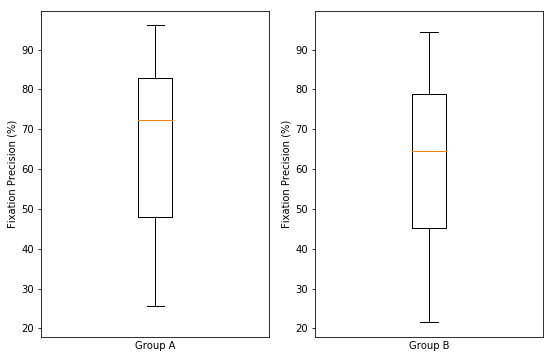

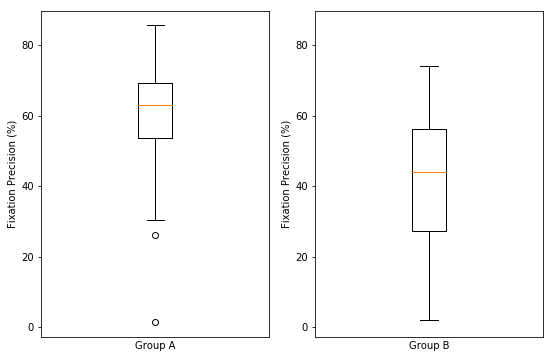

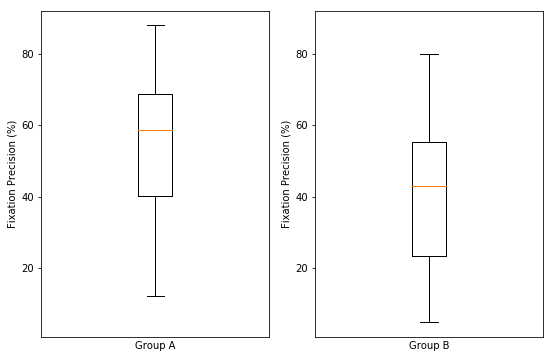

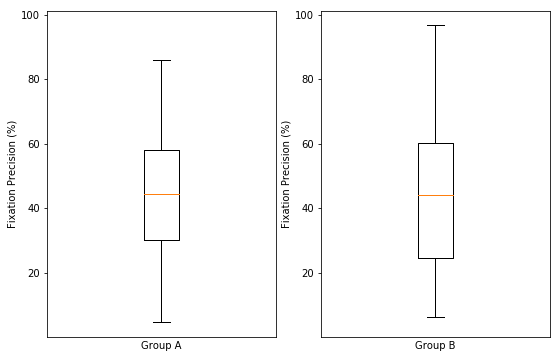

In [146]:
measure = "fixationPrecision"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]


db = "fixationPrecisionBoxplot"    
m1 = boxplot("Model 1 Fixation Precision", "Fixation Precision (%)", M1A, M1B)
m1.savefig("M1"+db)
m2 = boxplot("Model 2 Fixation Precision", "Fixation Precision (%)", M2A, M2B)
m2.savefig("M2"+db)
m3 = boxplot("Model 3 Fixation Precision", "Fixation Precision (%)", M3A, M3B)
m3.savefig("M3"+db)
m4 = boxplot("Model 4 Fixation Precision", "Fixation Precision (%)", M4A, M4B)
m4.savefig("M4"+db)

ImportError: No module named sem

In [96]:
measure = "fixationsPerSecond"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]

messyDirection = M1B + M3A
nonMessyDirection = M1A + M3B
messyVisibility = M2A + M4B
nonMessyVisibility = M2B + M4A

print len(messyDirection)
print measure + "\t|Mean\t\t|Std. Error of Mean\t|Standard diviation"
print "Messy direction \t|" + str(np.mean(messyDirection)) + "\t|" + str(stats.sem(messyDirection)) + "\t|" + str(np.std(messyDirection)) + "\t" + str(min(messyDirection)) + "\t" + str(max(messyDirection))
print "Non messy direction \t|" + str(np.mean(nonMessyDirection)) + "\t|" + str(stats.sem(nonMessyDirection)) + "\t|" + str(np.std(nonMessyDirection)) + "\t" + str(min(nonMessyDirection)) + "\t" + str(max(nonMessyDirection))
print "Messy visibility \t|" + str(np.mean(messyVisibility)) + "\t|" + str(stats.sem(messyVisibility)) + "\t|" + str(np.std(messyVisibility)) + "\t" + str(min(messyVisibility)) + "\t" + str(max(messyVisibility))
print "Non messy visibility \t|" + str(np.mean(nonMessyVisibility)) + "\t|" + str(stats.sem(nonMessyVisibility)) + "\t|" + str(np.std(nonMessyVisibility)) + "\t" + str(min(nonMessyVisibility)) + "\t" + str(max(nonMessyVisibility))

78
fixationsPerSecond	|Mean		|Std. Error of Mean	|Standard diviation
Messy direction 	|2.62049292461	|0.0573824276468	|0.503528759063	1.53830163185	3.95341382626
Non messy direction 	|2.65266949126	|0.0596731046152	|0.523629367883	1.20787534726	3.87622363839
Messy visibility 	|2.57636878863	|0.0421377606338	|0.369757348926	1.48901211748	3.59020852221
Non messy visibility 	|2.6238503562	|0.0631287160113	|0.553952234821	1.4835461248	3.95577644792


In [99]:
measure = "fixationDuration"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]

messyDirection = M1B + M3A
nonMessyDirection = M1A + M3B
messyVisibility = M2A + M4B
nonMessyVisibility = M2B + M4A

print len(messyDirection)
print measure + "\t|Mean\t\t|Std. Error of Mean\t|Standard diviation"
print "Messy direction \t|" + str(np.mean(messyDirection)) + "\t|" + str(stats.sem(messyDirection)) + "\t|" + str(np.std(messyDirection)) + "\t" + str(min(messyDirection)) + "\t" + str(max(messyDirection))
print "Non messy direction \t|" + str(np.mean(nonMessyDirection)) + "\t|" + str(stats.sem(nonMessyDirection)) + "\t|" + str(np.std(nonMessyDirection)) + "\t" + str(min(nonMessyDirection)) + "\t" + str(max(nonMessyDirection))
print "Messy visibility \t|" + str(np.mean(messyVisibility)) + "\t|" + str(stats.sem(messyVisibility)) + "\t|" + str(np.std(messyVisibility)) + "\t" + str(min(messyVisibility)) + "\t" + str(max(messyVisibility))
print "Non messy visibility \t|" + str(np.mean(nonMessyVisibility)) + "\t|" + str(stats.sem(nonMessyVisibility)) + "\t|" + str(np.std(nonMessyVisibility)) + "\t" + str(min(nonMessyVisibility)) + "\t" + str(max(nonMessyVisibility))

78
fixationDuration	|Mean		|Std. Error of Mean	|Standard diviation
Messy direction 	|7.86993393585	|0.788391548776	|6.91810776383	0.604255952381	29.6464444444
Non messy direction 	|8.07447071842	|0.953803510887	|8.3695918406	0.765142857143	52.8528888889
Messy visibility 	|10.9606386668	|0.950717457357	|8.34251183078	2.1864125	43.7795714286
Non messy visibility 	|14.4619270226	|0.851944827856	|7.47578552446	4.18637662338	37.6933529412


In [107]:
measure = "saccadeVelocityList"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]

messyDirection = M1B + M3A
nonMessyDirection = M1A + M3B
messyVisibility = M2A + M4B
nonMessyVisibility = M2B + M4A
print len(messyDirection)
print measure + "\t|Mean\t\t|Std. Error of Mean\t|Standard diviation"
print "Messy direction \t|" + str(np.mean(messyDirection)) + "\t|" + str(stats.sem(messyDirection)) + "\t|" + str(np.std(messyDirection)) + "\t" + str(min(messyDirection)) + "\t" + str(max(messyDirection))
print "Non messy direction \t|" + str(np.mean(nonMessyDirection)) + "\t|" + str(stats.sem(nonMessyDirection)) + "\t|" + str(np.std(nonMessyDirection)) + "\t" + str(min(nonMessyDirection)) + "\t" + str(max(nonMessyDirection))
print "Messy visibility \t|" + str(np.mean(messyVisibility)) + "\t|" + str(stats.sem(messyVisibility)) + "\t|" + str(np.std(messyVisibility)) + "\t" + str(min(messyVisibility)) + "\t" + str(max(messyVisibility))
print "Non messy visibility \t|" + str(np.mean(nonMessyVisibility)) + "\t|" + str(stats.sem(nonMessyVisibility)) + "\t|" + str(np.std(nonMessyVisibility)) + "\t" + str(min(nonMessyVisibility)) + "\t" + str(max(nonMessyVisibility))

78
saccadeVelocityList	|Mean		|Std. Error of Mean	|Standard diviation
Messy direction 	|4.46702078358	|0.136420055863	|1.19708113193	1.84045454545	7.97909090909
Non messy direction 	|4.73977891648	|0.150941402675	|1.32450543306	1.70230769231	9.0555952381
Messy visibility 	|3.35566538074	|0.0986177438618	|0.865367190352	1.69205128205	5.44625
Non messy visibility 	|3.72666898117	|0.121954260556	|1.07014429327	1.58277777778	7.24717948718


In [91]:
measure = "amountOfFixations"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]

messyDirection = M1B + M3A
nonMessyDirection = M1A + M3B
messyVisibility = M2A + M4B
nonMessyVisibility = M2B + M4A
print len(messyDirection)
print measure + "\t|Mean\t\t|Std. Error of Mean\t|Standard diviation"
print "Messy direction \t|" + str(np.mean(messyDirection)) + "\t|" + str(stats.sem(messyDirection)) + "\t|" + str(np.std(messyDirection)) + "\t" + str(min(messyDirection)) + "\t" + str(max(messyDirection))
print "Non messy direction \t|" + str(np.mean(nonMessyDirection)) + "\t|" + str(stats.sem(nonMessyDirection)) + "\t|" + str(np.std(nonMessyDirection)) + "\t" + str(min(nonMessyDirection)) + "\t" + str(max(nonMessyDirection))
print "Messy visibility \t|" + str(np.mean(messyVisibility)) + "\t|" + str(stats.sem(messyVisibility)) + "\t|" + str(np.std(messyVisibility)) + "\t" + str(min(messyVisibility)) + "\t" + str(max(messyVisibility))
print "Non messy visibility \t|" + str(np.mean(nonMessyVisibility)) + "\t|" + str(stats.sem(nonMessyVisibility)) + "\t|" + str(np.std(nonMessyVisibility)) + "\t" + str(min(nonMessyVisibility)) + "\t" + str(max(nonMessyVisibility))

78
amountOfFixations	|Mean		|Std. Error of Mean	|Standard diviation
Messy direction 	|72.7435897436	|4.21861137704	|37.0181645978	18	183
Non messy direction 	|62.2435897436	|3.7662373914	|33.048598984	12	191
Messy visibility 	|66.7051282051	|4.02345392376	|35.3056648953	16	242
Non messy visibility 	|54.5256410256	|4.10269131713	|36.0009702002	11	215


In [48]:
measure = "pupilDilationMean"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]

TUT = data["TUTX-Q01.png"][measure] + data["TUTX-Q02.png"][measure] + data["TUTX-Q03.png"][measure]

messyDirection = M1B + M3A
nonMessyDirection = M1A + M3B
messyVisibility = M2A + M4B
nonMessyVisibility = M2B + M4A
print len(messyDirection)
print measure + "\t|Mean\t\t|Variance\t|Standard diviation"
print "Messy direction \t|" + str(np.mean(messyDirection)) + "\t|" + str(np.var(messyDirection)) + "\t|" + str(np.std(messyDirection)) + "\t" + str(min(messyDirection)) + "\t" + str(max(messyDirection))
print "Non messy direction \t|" + str(np.mean(nonMessyDirection)) + "\t|" + str(np.var(nonMessyDirection)) + "\t|" + str(np.std(nonMessyDirection)) + "\t" + str(min(nonMessyDirection)) + "\t" + str(max(nonMessyDirection))
print "Messy visibility \t|" + str(np.mean(messyVisibility)) + "\t|" + str(np.var(messyVisibility)) + "\t|" + str(np.std(messyVisibility)) + "\t" + str(min(messyVisibility)) + "\t" + str(max(messyVisibility))
print "Non messy visibility \t|" + str(np.mean(nonMessyVisibility)) + "\t|" + str(np.var(nonMessyVisibility)) + "\t|" + str(np.std(nonMessyVisibility)) + "\t" + str(min(nonMessyVisibility)) + "\t" + str(max(nonMessyVisibility))
print ""
print "TUT \t" + str(np.mean(TUT)) + "\t" + str(np.var(TUT)) + "\t" + str(np.std(TUT)) + "\t" + str(min(nonMessyVisibility)) + "\t" + str(max(nonMessyVisibility))


KeyError: 'TUTX-Q01.png'

In [49]:
measure = "pupilDilationDiff"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]

messyDirection = M1B + M3A
nonMessyDirection = M1A + M3B
messyVisibility = M2A + M4B
nonMessyVisibility = M2B + M4A
print len(messyDirection)
print measure + "\t|Mean\t\t|Variance\t|Standard diviation"
print "Messy direction \t|" + str(np.mean(messyDirection)) + "\t|" + str(np.var(messyDirection)) + "\t|" + str(np.std(messyDirection)) + "\t" + str(min(messyDirection)) + "\t" + str(max(messyDirection))
print "Non messy direction \t|" + str(np.mean(nonMessyDirection)) + "\t|" + str(np.var(nonMessyDirection)) + "\t|" + str(np.std(nonMessyDirection)) + "\t" + str(min(nonMessyDirection)) + "\t" + str(max(nonMessyDirection))
print "Messy visibility \t|" + str(np.mean(messyVisibility)) + "\t|" + str(np.var(messyVisibility)) + "\t|" + str(np.std(messyVisibility)) + "\t" + str(min(messyVisibility)) + "\t" + str(max(messyVisibility))
print "Non messy visibility \t|" + str(np.mean(nonMessyVisibility)) + "\t|" + str(np.var(nonMessyVisibility)) + "\t|" + str(np.std(nonMessyVisibility)) + "\t" + str(min(nonMessyVisibility)) + "\t" + str(max(nonMessyVisibility))

KeyError: 'pupilDilationDiff'

In [103]:
measure = "fixationPrecision"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]

messyDirection = M1B + M3A
nonMessyDirection = M1A + M3B
messyVisibility = M2A + M4B
nonMessyVisibility = M2B + M4A
print len(messyDirection)
print measure + "\t|Mean\t\t|Std. Error of Mean\t|Standard diviation"
print "Messy direction \t|" + str(np.mean(messyDirection)) + "\t|" + str(stats.sem(messyDirection)) + "\t|" + str(np.std(messyDirection)) + "\t" + str(min(messyDirection)) + "\t" + str(max(messyDirection))
print "Non messy direction \t|" + str(np.mean(nonMessyDirection)) + "\t|" + str(stats.sem(nonMessyDirection)) + "\t|" + str(np.std(nonMessyDirection)) + "\t" + str(min(nonMessyDirection)) + "\t" + str(max(nonMessyDirection))
print "Messy visibility \t|" + str(np.mean(messyVisibility)) + "\t|" + str(stats.sem(messyVisibility)) + "\t|" + str(np.std(messyVisibility)) + "\t" + str(min(messyVisibility)) + "\t" + str(max(messyVisibility))
print "Non messy visibility \t|" + str(np.mean(nonMessyVisibility)) + "\t|" + str(stats.sem(nonMessyVisibility)) + "\t|" + str(np.std(nonMessyVisibility)) + "\t" + str(min(nonMessyVisibility)) + "\t" + str(max(nonMessyVisibility))

78
fixationPrecision	|Mean		|Std. Error of Mean	|Standard diviation
Messy direction 	|58.2608886984	|2.24336206374	|19.6854222173	12.1212121212	94.3181818182
Non messy direction 	|56.0232144555	|2.68989901679	|23.603768078	4.7619047619	96.0526315789
Messy visibility 	|52.6345066747	|2.56191309946	|22.4806962114	1.49253731343	96.6666666667
Non messy visibility 	|42.5675987685	|2.30036570802	|20.1856271658	2.0	85.9649122807


In [97]:
measure = "fixationsPerSecond"
M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

messyL = M1BL + M3AL + M2AL + M4BL
messyG = M1BG + M3AG + M2AG + M4BG
nonMessyL = M1AL + M3BL + M2BL + M4AL + messyL
nonMessyG = M1AG + M3BG + M2BG + M4AG + messyG

print len(nonMessyG)
print measure + "\t|Mean\t\t|Std Error\t|Standard diviation"
print "Messy Global \t\t|" + str(np.mean(messyG)) + "\t|" + str(stats.sem(messyG)) + "\t|" + str(np.std(messyG))
print "Messy Local \t\t|" + str(np.mean(messyL)) + "\t|" + str(stats.sem(messyL)) + "\t|" + str(np.std(messyL))
print "Non Messy Global \t|" + str(np.mean(nonMessyG)) + "\t|" + str(stats.sem(nonMessyG)) + "\t|" + str(np.std(nonMessyG)) + "\t" + str(min(nonMessyG)) + "\t" + str(max(nonMessyG))
print "Non Messy Local \t|" + str(np.mean(nonMessyL)) + "\t|" + str(stats.sem(nonMessyL)) + "\t|" + str(np.std(nonMessyL)) + "\t" + str(min(nonMessyL)) + "\t" + str(max(nonMessyL))

156
fixationsPerSecond	|Mean		|Std Error	|Standard diviation
Messy Global 		|2.53430623294	|0.0490273469297	|0.430213223317
Messy Local 		|2.66255548031	|0.0507000122614	|0.444890802034
Non Messy Global 	|2.54745644738	|0.0395759194078	|0.492716223125	1.20787534726	3.95577644792
Non Messy Local 	|2.68923433297	|0.0388814606831	|0.484070281728	1.48901211748	3.95341382626


In [100]:
measure = "fixationDuration"
M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

messyL = M1BL + M3AL + M2AL + M4BL
messyG = M1BG + M3AG + M2AG + M4BG
nonMessyL = M1AL + M3BL + M2BL + M4AL + messyL
nonMessyG = M1AG + M3BG + M2BG + M4AG + messyG

print len(nonMessyG)
print measure + "\t|Mean\t\t|Std Error\t|Standard diviation"
print "Messy Global \t\t|" + str(np.mean(messyG)) + "\t|" + str(stats.sem(messyG)) + "\t|" + str(np.std(messyG))
print "Messy Local \t\t|" + str(np.mean(messyL)) + "\t|" + str(stats.sem(messyL)) + "\t|" + str(np.std(messyL))
print "Non Messy Global \t|" + str(np.mean(nonMessyG)) + "\t|" + str(stats.sem(nonMessyG)) + "\t|" + str(np.std(nonMessyG)) + "\t" + str(min(nonMessyG)) + "\t" + str(max(nonMessyG))
print "Non Messy Local \t|" + str(np.mean(nonMessyL)) + "\t|" + str(stats.sem(nonMessyL)) + "\t|" + str(np.std(nonMessyL)) + "\t" + str(min(nonMessyL)) + "\t" + str(max(nonMessyL))

156
fixationDuration	|Mean		|Std Error	|Standard diviation
Messy Global 		|7.56366250908	|0.616779855796	|5.41222126947
Messy Local 		|11.2669100936	|1.05734773636	|9.27818873164
Non Messy Global 	|8.22685180852	|0.441450423154	|5.49601344576	1.32891304348	32.60612
Non Messy Local 	|12.4566333633	|0.790469618984	|9.84126739161	0.604255952381	52.8528888889


In [108]:
measure = "saccadeVelocityList"
M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

messyL = M1BL + M3AL + M2AL + M4BL
messyG = M1BG + M3AG + M2AG + M4BG
nonMessyL = M1AL + M3BL + M2BL + M4AL + messyL
nonMessyG = M1AG + M3BG + M2BG + M4AG + messyG

print len(nonMessyG)
print measure + "\t|Mean\t\t|Std Error\t|Standard diviation"
print "Messy Global \t\t|" + str(np.mean(messyG)) + "\t|" + str(stats.sem(messyG)) + "\t|" + str(np.std(messyG))
print "Messy Local \t\t|" + str(np.mean(messyL)) + "\t|" + str(stats.sem(messyL)) + "\t|" + str(np.std(messyL))
print "Non Messy Global \t|" + str(np.mean(nonMessyG)) + "\t|" + str(stats.sem(nonMessyG)) + "\t|" + str(np.std(nonMessyG)) + "\t" + str(min(nonMessyG)) + "\t" + str(max(nonMessyG))
print "Non Messy Local \t|" + str(np.mean(nonMessyL)) + "\t|" + str(stats.sem(nonMessyL)) + "\t|" + str(np.std(nonMessyL)) + "\t" + str(min(nonMessyL)) + "\t" + str(max(nonMessyL))

156
saccadeVelocityList	|Mean		|Std Error	|Standard diviation
Messy Global 		|4.15620092807	|0.127393480178	|1.11787325175
Messy Local 		|3.66648523625	|0.136270724143	|1.1957707514
Non Messy Global 	|4.28172548167	|0.100691059734	|1.2535935841	2.053	9.0555952381
Non Messy Local 	|3.86284154931	|0.0983294026637	|1.22419119069	1.58277777778	7.31032786885


In [54]:
measure = "duration"
M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

messyL = M1BL + M3AL + M2AL + M4BL
messyG = M1BG + M3AG + M2AG + M4BG
nonMessyL = M1AL + M3BL + M2BL + M4AL
nonMessyG = M1AG + M3BG + M2BG + M4AG

print measure + "\t|Mean\t\t|Variance\t|Standard diviation"
print "Messy Global \t\t|" + str(np.mean(messyG)) + "\t|" + str(np.var(messyG)) + "\t|" + str(np.std(messyG))
print "Messy Local \t\t|" + str(np.mean(messyL)) + "\t|" + str(np.var(messyL)) + "\t|" + str(np.std(messyL))
print "Non Messy Global \t|" + str(np.mean(nonMessyG)) + "\t|" + str(np.var(nonMessyG)) + "\t|" + str(np.std(nonMessyG))
print "Non Messy Local \t|" + str(np.mean(nonMessyL)) + "\t|" + str(np.var(nonMessyL)) + "\t|" + str(np.std(nonMessyL))

duration	|Mean		|Variance	|Standard diviation
Messy Global 		|34.0361923077	|199.135913694	|14.1115524906
Messy Local 		|20.5900512821	|95.287150382	|9.76151373415
Non Messy Global 	|29.2739358974	|237.121197316	|15.3987401211
Non Messy Local 	|16.7408076923	|97.5008628476	|9.87425252096


In [92]:
measure = "amountOfFixations"
M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

messyL = M1BL + M3AL + M2AL + M4BL
messyG = M1BG + M3AG + M2AG + M4BG
nonMessyL = M1AL + M3BL + M2BL + M4AL + messyL
nonMessyG = M1AG + M3BG + M2BG + M4AG + messyG
print len(nonMessyG)
print measure + "\t|Mean\t\t|Std Error\t|Standard diviation"
print "Messy Global \t\t|" + str(np.mean(messyG)) + "\t|" + str(stats.sem(messyG)) + "\t|" + str(np.std(messyG))
print "Messy Local \t\t|" + str(np.mean(messyL)) + "\t|" + str(stats.sem(messyL)) + "\t|" + str(np.std(messyL))
print "Non Messy Global \t|" + str(np.mean(nonMessyG)) + "\t|" + str(stats.sem(nonMessyG)) + "\t|" + str(np.std(nonMessyG)) + "\t" + str(min(nonMessyG)) + "\t" + str(max(nonMessyG))
print "Non Messy Local \t|" + str(np.mean(nonMessyL)) + "\t|" + str(stats.sem(nonMessyL)) + "\t|" + str(np.std(nonMessyL)) + "\t" + str(min(nonMessyL)) + "\t" + str(max(nonMessyL))

156
amountOfFixations	|Mean		|Std Error	|Standard diviation
Messy Global 		|85.6025641026	|4.32073810863	|37.9143230305
Messy Local 		|53.8461538462	|3.00072568219	|26.3312609975
Non Messy Global 	|78.9743589744	|3.04054417986	|37.8544697625	11	242
Non Messy Local 	|49.1346153846	|2.14429989651	|26.6963184196	12	191


In [ ]:
### measure = "pupilDilationDiff"
M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

messyL = M1BL + M3AL + M2AL + M4BL
messyG = M1BG + M3AG + M2AG + M4BG
nonMessyL = M1AL + M3BL + M2BL + M4AL + messyL
nonMessyG = M1AG + M3BG + M2BG + M4AG + messyG
print len(nonMessyG)
print measure + "\t|Mean\t\t|Variance\t|Standard diviation"
print "Messy Global \t\t|" + str(np.mean(messyG)) + "\t|" + str(np.var(messyG)) + "\t|" + str(np.std(messyG))
print "Messy Local \t\t|" + str(np.mean(messyL)) + "\t|" + str(np.var(messyL)) + "\t|" + str(np.std(messyL))
print "Non Messy Global \t|" + str(np.mean(nonMessyG)) + "\t|" + str(np.var(nonMessyG)) + "\t|" + str(np.std(nonMessyG)) + "\t" + str(min(nonMessyG)) + "\t" + str(max(nonMessyG))
print "Non Messy Local \t|" + str(np.mean(nonMessyL)) + "\t|" + str(np.var(nonMessyL)) + "\t|" + str(np.std(nonMessyL)) + "\t" + str(min(nonMessyL)) + "\t" + str(max(nonMessyL))

In [104]:
measure = "fixationPrecision"
M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

messyL = M1BL + M3AL + M2AL + M4BL
messyG = M1BG + M3AG + M2AG + M4BG
nonMessyL = M1AL + M3BL + M2BL + M4AL + messyL
nonMessyG = M1AG + M3BG + M2BG + M4AG + messyG
print len(nonMessyG)
print measure + "\t|Mean\t\t|Std Error\t|Standard diviation"
print "Messy Global \t\t|" + str(np.mean(messyG)) + "\t|" + str(stats.sem(messyG)) + "\t|" + str(np.std(messyG))
print "Messy Local \t\t|" + str(np.mean(messyL)) + "\t|" + str(stats.sem(messyL)) + "\t|" + str(np.std(messyL))
print "Non Messy Global \t|" + str(np.mean(nonMessyG)) + "\t|" + str(stats.sem(nonMessyG)) + "\t|" + str(np.std(nonMessyG)) + "\t" + str(min(nonMessyG)) + "\t" + str(max(nonMessyG))
print "Non Messy Local \t|" + str(np.mean(nonMessyL)) + "\t|" + str(stats.sem(nonMessyL)) + "\t|" + str(np.std(nonMessyL)) + "\t" + str(min(nonMessyL)) + "\t" + str(max(nonMessyL))

156
fixationPrecision	|Mean		|Std Error	|Standard diviation
Messy Global 		|56.5858777402	|2.42033271593	|21.2383333879
Messy Local 		|54.3095176329	|2.43104361267	|21.3323211253
Non Messy Global 	|54.9430111936	|1.8268077342	|22.7435728756	2.32558139535	96.0526315789
Non Messy Local 	|49.800093105	|1.74199617642	|21.6876774965	1.49253731343	96.6666666667


In [105]:
measure = "fixationsPerSecond"
M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

messyDirectionGlobal = M1BG + M3AG
nonMessyDirectionGlobal = M1AG + M3BG
messyDirectionLocal = M1BL + M3AL
nonMessyDirectionLocal = M1AL + M3BL
messyVisibilityGlobal = M2AG + M4BG
nonMessyVisibilityGlobal = M2BG + M4AG
messyVisibilityLocal = M2AL + M4BL
nonMessyVisibilityLocal = M2BL + M4AL
print len(messyDirectionGlobal)
print measure + "\t\t|Mean\t\t|Std. error\t|Standard deviation"
print "Messy direction global \t\t|" + str(np.mean(messyDirectionGlobal)) + "\t|" + str(stats.sem(messyDirectionGlobal)) + "\t|" + str(np.std(messyDirectionGlobal)) + "\t" + str(min(messyDirectionGlobal)) + "\t" + str(max(messyDirectionGlobal))
print "Non messy direction global \t|" + str(np.mean(nonMessyDirectionGlobal)) + "\t|" + str(stats.sem(nonMessyDirectionGlobal)) + "\t|" + str(np.std(nonMessyDirectionGlobal)) + "\t" + str(min(nonMessyDirectionGlobal)) + "\t" + str(max(nonMessyDirectionGlobal))
print "Messy direction local \t\t|" + str(np.mean(messyDirectionLocal)) + "\t|" + str(stats.sem(messyDirectionLocal)) + "\t|" + str(np.std(messyDirectionLocal)) + "\t" + str(min(messyDirectionLocal)) + "\t" + str(max(messyDirectionLocal))
print "Non messy direction local \t|" + str(np.mean(nonMessyDirectionLocal)) + "\t|" + str(stats.sem(nonMessyDirectionLocal)) + "\t|" + str(np.std(nonMessyDirectionLocal)) + "\t" + str(min(nonMessyDirectionLocal)) + "\t" + str(max(nonMessyDirectionLocal))
print "Messy visibility global \t|" + str(np.mean(messyVisibilityGlobal)) + "\t|" + str(stats.sem(messyVisibilityGlobal)) + "\t|" + str(np.std(messyVisibilityGlobal)) + "\t" + str(min(messyVisibilityGlobal)) + "\t" + str(max(messyVisibilityGlobal))
print "Non messy visibility global \t|" + str(np.mean(nonMessyVisibilityGlobal)) + "\t|" + str(stats.sem(nonMessyVisibilityGlobal)) + "\t|" + str(np.std(nonMessyVisibilityGlobal)) + "\t" + str(min(nonMessyVisibilityGlobal)) + "\t" + str(max(nonMessyVisibilityGlobal))
print "Messy visibility local \t\t|" + str(np.mean(messyVisibilityLocal)) + "\t|" + str(stats.sem(messyVisibilityLocal)) + "\t|" + str(np.std(messyVisibilityLocal)) + "\t" + str(min(messyVisibilityLocal)) + "\t" + str(max(messyVisibilityLocal))
print "Non messy visibility local \t|" + str(np.mean(nonMessyVisibilityLocal)) + "\t|" + str(stats.sem(nonMessyVisibilityLocal)) + "\t|" + str(np.std(nonMessyVisibilityLocal)) + "\t" + str(min(nonMessyVisibilityLocal)) + "\t" + str(max(nonMessyVisibilityLocal))

39
fixationsPerSecond		|Mean		|Std. error	|Standard deviation
Messy direction global 		|2.44965007007	|0.0808758804935	|0.498552410217	1.53830163185	3.76789751319
Non messy direction global 	|2.42643302371	|0.0804666047773	|0.496029465261	1.20787534726	3.87622363839
Messy direction local 		|2.79133577916	|0.0725754334927	|0.447385018494	1.59172304019	3.95341382626
Non messy direction local 	|2.87890595882	|0.0725411536384	|0.44717370328	2.06540447504	3.7459658829
Messy visibility global 	|2.61896239581	|0.0531331489044	|0.327534727128	1.82568661692	3.59020852221
Non messy visibility global 	|2.69478029994	|0.0915032639327	|0.564064001504	1.4835461248	3.95577644792
Messy visibility local 		|2.53377518145	|0.0654002989589	|0.403154518701	1.48901211748	3.27715355805
Non messy visibility local 	|2.55292041245	|0.0866778435376	|0.53431811245	1.55816331499	3.58757264835


In [101]:
measure = "fixationDuration"
M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

messyDirectionGlobal = M1BG + M3AG
nonMessyDirectionGlobal = M1AG + M3BG
messyDirectionLocal = M1BL + M3AL
nonMessyDirectionLocal = M1AL + M3BL
messyVisibilityGlobal = M2AG + M4BG
nonMessyVisibilityGlobal = M2BG + M4AG
messyVisibilityLocal = M2AL + M4BL
nonMessyVisibilityLocal = M2BL + M4AL
print len(messyDirectionGlobal)
print measure + "\t\t|Mean\t\t|Std. error\t|Standard deviation"
print "Messy direction global \t\t|" + str(np.mean(messyDirectionGlobal)) + "\t|" + str(stats.sem(messyDirectionGlobal)) + "\t|" + str(np.std(messyDirectionGlobal)) + "\t" + str(min(messyDirectionGlobal)) + "\t" + str(max(messyDirectionGlobal))
print "Non messy direction global \t|" + str(np.mean(nonMessyDirectionGlobal)) + "\t|" + str(stats.sem(nonMessyDirectionGlobal)) + "\t|" + str(np.std(nonMessyDirectionGlobal)) + "\t" + str(min(nonMessyDirectionGlobal)) + "\t" + str(max(nonMessyDirectionGlobal))
print "Messy direction local \t\t|" + str(np.mean(messyDirectionLocal)) + "\t|" + str(stats.sem(messyDirectionLocal)) + "\t|" + str(np.std(messyDirectionLocal)) + "\t" + str(min(messyDirectionLocal)) + "\t" + str(max(messyDirectionLocal))
print "Non messy direction local \t|" + str(np.mean(nonMessyDirectionLocal)) + "\t|" + str(stats.sem(nonMessyDirectionLocal)) + "\t|" + str(np.std(nonMessyDirectionLocal)) + "\t" + str(min(nonMessyDirectionLocal)) + "\t" + str(max(nonMessyDirectionLocal))
print "Messy visibility global \t|" + str(np.mean(messyVisibilityGlobal)) + "\t|" + str(stats.sem(messyVisibilityGlobal)) + "\t|" + str(np.std(messyVisibilityGlobal)) + "\t" + str(min(messyVisibilityGlobal)) + "\t" + str(max(messyVisibilityGlobal))
print "Non messy visibility global \t|" + str(np.mean(nonMessyVisibilityGlobal)) + "\t|" + str(stats.sem(nonMessyVisibilityGlobal)) + "\t|" + str(np.std(nonMessyVisibilityGlobal)) + "\t" + str(min(nonMessyVisibilityGlobal)) + "\t" + str(max(nonMessyVisibilityGlobal))
print "Messy visibility local \t\t|" + str(np.mean(messyVisibilityLocal)) + "\t|" + str(stats.sem(messyVisibilityLocal)) + "\t|" + str(np.std(messyVisibilityLocal)) + "\t" + str(min(messyVisibilityLocal)) + "\t" + str(max(messyVisibilityLocal))
print "Non messy visibility local \t|" + str(np.mean(nonMessyVisibilityLocal)) + "\t|" + str(stats.sem(nonMessyVisibilityLocal)) + "\t|" + str(np.std(nonMessyVisibilityLocal)) + "\t" + str(min(nonMessyVisibilityLocal)) + "\t" + str(max(nonMessyVisibilityLocal))

39
fixationDuration		|Mean		|Std. error	|Standard deviation
Messy direction global 		|5.85660028061	|0.520415576208	|3.20805706534	1.68221495327	15.531326087
Non messy direction global 	|6.50338898171	|0.69086770101	|4.2587945303	1.32891304348	15.7563125
Messy direction local 		|9.88326759108	|1.42645839605	|8.79328011124	0.604255952381	29.6464444444
Non messy direction local 	|9.64555245514	|1.75488947514	|10.8178652542	0.765142857143	52.8528888889
Messy visibility global 	|9.27072473755	|1.05711281454	|6.51648103667	2.1864125	32.60612
Non messy visibility global 	|11.2766932342	|0.902504545286	|5.5634116567	4.18637662338	28.1388
Messy visibility local 		|12.650552596	|1.54765411626	|9.54038070601	3.66365625	43.7795714286
Non messy visibility local 	|17.647160811	|1.26211769178	|7.78021597258	5.68232692308	37.6933529412


In [109]:
measure = "saccadeVelocityList"
M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

messyDirectionGlobal = M1BG + M3AG
nonMessyDirectionGlobal = M1AG + M3BG
messyDirectionLocal = M1BL + M3AL
nonMessyDirectionLocal = M1AL + M3BL
messyVisibilityGlobal = M2AG + M4BG
nonMessyVisibilityGlobal = M2BG + M4AG
messyVisibilityLocal = M2AL + M4BL
nonMessyVisibilityLocal = M2BL + M4AL

print len(messyDirectionGlobal)
print measure + "\t\t|Mean\t\t|Std. error\t|Standard deviation"
print "Messy direction global \t\t|" + str(np.mean(messyDirectionGlobal)) + "\t|" + str(stats.sem(messyDirectionGlobal)) + "\t|" + str(np.std(messyDirectionGlobal)) + "\t" + str(min(messyDirectionGlobal)) + "\t" + str(max(messyDirectionGlobal))
print "Non messy direction global \t|" + str(np.mean(nonMessyDirectionGlobal)) + "\t|" + str(stats.sem(nonMessyDirectionGlobal)) + "\t|" + str(np.std(nonMessyDirectionGlobal)) + "\t" + str(min(nonMessyDirectionGlobal)) + "\t" + str(max(nonMessyDirectionGlobal))
print "Messy direction local \t\t|" + str(np.mean(messyDirectionLocal)) + "\t|" + str(stats.sem(messyDirectionLocal)) + "\t|" + str(np.std(messyDirectionLocal)) + "\t" + str(min(messyDirectionLocal)) + "\t" + str(max(messyDirectionLocal))
print "Non messy direction local \t|" + str(np.mean(nonMessyDirectionLocal)) + "\t|" + str(stats.sem(nonMessyDirectionLocal)) + "\t|" + str(np.std(nonMessyDirectionLocal)) + "\t" + str(min(nonMessyDirectionLocal)) + "\t" + str(max(nonMessyDirectionLocal))
print "Messy visibility global \t|" + str(np.mean(messyVisibilityGlobal)) + "\t|" + str(stats.sem(messyVisibilityGlobal)) + "\t|" + str(np.std(messyVisibilityGlobal)) + "\t" + str(min(messyVisibilityGlobal)) + "\t" + str(max(messyVisibilityGlobal))
print "Non messy visibility global \t|" + str(np.mean(nonMessyVisibilityGlobal)) + "\t|" + str(stats.sem(nonMessyVisibilityGlobal)) + "\t|" + str(np.std(nonMessyVisibilityGlobal)) + "\t" + str(min(nonMessyVisibilityGlobal)) + "\t" + str(max(nonMessyVisibilityGlobal))
print "Messy visibility local \t\t|" + str(np.mean(messyVisibilityLocal)) + "\t|" + str(stats.sem(messyVisibilityLocal)) + "\t|" + str(np.std(messyVisibilityLocal)) + "\t" + str(min(messyVisibilityLocal)) + "\t" + str(max(messyVisibilityLocal))
print "Non messy visibility local \t|" + str(np.mean(nonMessyVisibilityLocal)) + "\t|" + str(stats.sem(nonMessyVisibilityLocal)) + "\t|" + str(np.std(nonMessyVisibilityLocal)) + "\t" + str(min(nonMessyVisibilityLocal)) + "\t" + str(max(nonMessyVisibilityLocal))

39
saccadeVelocityList		|Mean		|Std. error	|Standard deviation
Messy direction global 		|4.77088711064	|0.169558523577	|1.04522893706	3.16331081081	7.97909090909
Non messy direction global 	|4.97983802922	|0.221241379321	|1.36382345672	2.54871794872	9.0555952381
Messy direction local 		|4.16315445653	|0.204478376963	|1.26048937025	1.84045454545	6.87466666667
Non messy direction local 	|4.49971980374	|0.200876900514	|1.2382883784	1.70230769231	7.31032786885
Messy visibility global 	|3.54151474551	|0.130897657592	|0.806907353414	2.06419354839	5.44625
Non messy visibility global 	|3.83466204133	|0.178292499586	|1.09906878107	2.053	7.24717948718
Messy visibility local 		|3.16981601596	|0.143044095015	|0.881783022354	1.69205128205	5.41119402985
Non messy visibility local 	|3.61867592102	|0.166949443122	|1.02914548497	1.58277777778	5.82442307692


In [95]:
measure = "amountOfFixations"
M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

messyDirectionGlobal = M1BG + M3AG
nonMessyDirectionGlobal = M1AG + M3BG
messyDirectionLocal = M1BL + M3AL
nonMessyDirectionLocal = M1AL + M3BL
messyVisibilityGlobal = M2AG + M4BG
nonMessyVisibilityGlobal = M2BG + M4AG
messyVisibilityLocal = M2AL + M4BL
nonMessyVisibilityLocal = M2BL + M4AL
print len(messyDirectionGlobal)
print measure + "\t\t|Mean\t\t|Std. error\t|Standard deviation"
print "Messy direction global \t\t|" + str(np.mean(messyDirectionGlobal)) + "\t|" + str(stats.sem(messyDirectionGlobal)) + "\t|" + str(np.std(messyDirectionGlobal)) + "\t" + str(min(messyDirectionGlobal)) + "\t" + str(max(messyDirectionGlobal))
print "Non messy direction global \t|" + str(np.mean(nonMessyDirectionGlobal)) + "\t|" + str(stats.sem(nonMessyDirectionGlobal)) + "\t|" + str(np.std(nonMessyDirectionGlobal)) + "\t" + str(min(nonMessyDirectionGlobal)) + "\t" + str(max(nonMessyDirectionGlobal))
print "Messy direction local \t\t|" + str(np.mean(messyDirectionLocal)) + "\t|" + str(stats.sem(messyDirectionLocal)) + "\t|" + str(np.std(messyDirectionLocal)) + "\t" + str(min(messyDirectionLocal)) + "\t" + str(max(messyDirectionLocal))
print "Non messy direction local \t|" + str(np.mean(nonMessyDirectionLocal)) + "\t|" + str(stats.sem(nonMessyDirectionLocal)) + "\t|" + str(np.std(nonMessyDirectionLocal)) + "\t" + str(min(nonMessyDirectionLocal)) + "\t" + str(max(nonMessyDirectionLocal))
print "Messy visibility global \t|" + str(np.mean(messyVisibilityGlobal)) + "\t|" + str(stats.sem(messyVisibilityGlobal)) + "\t|" + str(np.std(messyVisibilityGlobal)) + "\t" + str(min(messyVisibilityGlobal)) + "\t" + str(max(messyVisibilityGlobal))
print "Non messy visibility global \t|" + str(np.mean(nonMessyVisibilityGlobal)) + "\t|" + str(stats.sem(nonMessyVisibilityGlobal)) + "\t|" + str(np.std(nonMessyVisibilityGlobal)) + "\t" + str(min(nonMessyVisibilityGlobal)) + "\t" + str(max(nonMessyVisibilityGlobal))
print "Messy visibility local \t\t|" + str(np.mean(messyVisibilityLocal)) + "\t|" + str(stats.sem(messyVisibilityLocal)) + "\t|" + str(np.std(messyVisibilityLocal)) + "\t" + str(min(messyVisibilityLocal)) + "\t" + str(max(messyVisibilityLocal))
print "Non messy visibility local \t|" + str(np.mean(nonMessyVisibilityLocal)) + "\t|" + str(stats.sem(nonMessyVisibilityLocal)) + "\t|" + str(np.std(nonMessyVisibilityLocal)) + "\t" + str(min(nonMessyVisibilityLocal)) + "\t" + str(max(nonMessyVisibilityLocal))

39
amountOfFixations		|Mean		|Std. error	|Standard deviation
Messy direction global 		|89.5641025641	|5.67433729528	|34.9789642806	35	183
Non messy direction global 	|73.8205128205	|4.78708222912	|29.5095567266	27	140
Messy direction local 		|55.9230769231	|5.00342455132	|30.8431803669	18	170
Non messy direction local 	|50.6666666667	|5.24543800679	|32.3350515007	12	191
Messy visibility global 	|81.641025641	|6.52943994055	|40.2501710011	23	242
Non messy visibility global 	|70.8717948718	|6.89385294917	|42.4965636542	11	215
Messy visibility local 		|51.7692307692	|3.35112556644	|20.6577253675	16	97
Non messy visibility local 	|38.1794871795	|2.57410330413	|15.8678384531	14	92


In [62]:
print data["M3B-Q15.png"]["duration"]

[6.109, 6.301, 8.112, 5.649, 5.81, 10.547]


In [63]:
measure = "duration"
M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

messyDirectionGlobal = M1BG + M3AG
nonMessyDirectionGlobal = M1AG + M3BG
messyDirectionLocal = M1BL + M3AL
nonMessyDirectionLocal = M1AL + M3BL
messyVisibilityGlobal = M2AG + M4BG
nonMessyVisibilityGlobal = M2BG + M4AG
messyVisibilityLocal = M2AL + M4BL
nonMessyVisibilityLocal = M2BL + M4AL

print len(messyDirectionGlobal)
print measure + "\t|Mean\t\t|Variance\t|Standard deviation"
print "Messy direction global \t|" + str(np.mean(messyDirectionGlobal)) + "\t|" + str(np.var(messyDirectionGlobal)) + "\t|" + str(np.std(messyDirectionGlobal)) + "\t" + str(min(messyDirectionGlobal)) + "\t" + str(max(messyDirectionGlobal))
print "Non messy direction global \t|" + str(np.mean(nonMessyDirectionGlobal)) + "\t|" + str(np.var(nonMessyDirectionGlobal)) + "\t|" + str(np.std(nonMessyDirectionGlobal)) + "\t" + str(min(nonMessyDirectionGlobal)) + "\t" + str(max(nonMessyDirectionGlobal))
print "Messy direction local \t|" + str(np.mean(messyDirectionLocal)) + "\t|" + str(np.var(messyDirectionLocal)) + "\t|" + str(np.std(messyDirectionLocal)) + "\t" + str(min(messyDirectionLocal)) + "\t" + str(max(messyDirectionLocal))
print "Non messy direction local \t|" + str(np.mean(nonMessyDirectionLocal)) + "\t|" + str(np.var(nonMessyDirectionLocal)) + "\t|" + str(np.std(nonMessyDirectionLocal)) + "\t" + str(min(nonMessyDirectionLocal)) + "\t" + str(max(nonMessyDirectionLocal))
print "Messy visibility global \t|" + str(np.mean(messyVisibilityGlobal)) + "\t|" + str(np.var(messyVisibilityGlobal)) + "\t|" + str(np.std(messyVisibilityGlobal)) + "\t" + str(min(messyVisibilityGlobal)) + "\t" + str(max(messyVisibilityGlobal))
print "Non messy visibility global \t|" + str(np.mean(nonMessyVisibilityGlobal)) + "\t|" + str(np.var(nonMessyVisibilityGlobal)) + "\t|" + str(np.std(nonMessyVisibilityGlobal)) + "\t" + str(min(nonMessyVisibilityGlobal)) + "\t" + str(max(nonMessyVisibilityGlobal))
print "Messy visibility local \t|" + str(np.mean(messyVisibilityLocal)) + "\t|" + str(np.var(messyVisibilityLocal)) + "\t|" + str(np.std(messyVisibilityLocal)) + "\t" + str(min(messyVisibilityLocal)) + "\t" + str(max(messyVisibilityLocal))
print "Non messy visibility local \t|" + str(np.mean(nonMessyVisibilityLocal)) + "\t|" + str(np.var(nonMessyVisibilityLocal)) + "\t|" + str(np.std(nonMessyVisibilityLocal)) + "\t" + str(min(nonMessyVisibilityLocal)) + "\t" + str(max(nonMessyVisibilityLocal))

39
duration	|Mean		|Variance	|Standard deviation
Messy direction global 	|37.2066666667	|178.059151043	|13.343880659	9.289	70.313
Non messy direction global 	|31.4074358974	|168.78818481	|12.9918507077	11.246	64.504
Messy direction local 	|20.4787179487	|121.513776561	|11.0233287423	5.162	54.807
Non messy direction local 	|17.6707179487	|124.921438305	|11.1768259495	5.649	66.829
Messy visibility global 	|30.8657179487	|200.108861023	|14.1459839185	10.154	84.81
Non messy visibility global 	|27.1404358974	|296.350565323	|17.2148356171	5.239	87.542
Messy visibility local 	|20.7013846154	|69.0357339803	|8.30877451736	4.983	40.268
Non messy visibility local 	|15.8108974359	|68.3508212202	|8.26745554692	5.793	43.841


In [64]:
measure = "accuracy"
M1AL = []
for index in xrange(len(data["M1A-Q01.png"][measure])):
    M1AL.append(data["M1A-Q01.png"][measure][index]+data["M1A-Q02.png"][measure][index]+data["M1A-Q03.png"][measure][index])
M1AG = []
for index in xrange(len(data["M1A-Q04.png"][measure])):
    M1AG.append(data["M1A-Q04.png"][measure][index]+data["M1A-Q05.png"][measure][index]+data["M1A-Q06.png"][measure][index])
M1BL = []
for index in xrange(len(data["M1B-Q01.png"][measure])):
    M1BL.append(data["M1B-Q01.png"][measure][index]+data["M1B-Q02.png"][measure][index]+data["M1B-Q03.png"][measure][index])
M1BG = []
for index in xrange(len(data["M1B-Q04.png"][measure])):
    M1BG.append(data["M1B-Q04.png"][measure][index]+data["M1B-Q05.png"][measure][index]+data["M1B-Q06.png"][measure][index])
M2AL = []
for index in xrange(len(data["M2A-Q07.png"][measure])):
    M2AL.append(data["M2A-Q07.png"][measure][index]+data["M2A-Q08.png"][measure][index]+data["M2A-Q09.png"][measure][index])
M2AG = []
for index in xrange(len(data["M2A-Q10.png"][measure])):
    M2AG.append(data["M2A-Q10.png"][measure][index]+data["M2A-Q11.png"][measure][index]+data["M2A-Q12.png"][measure][index])
M2BL = []
for index in xrange(len(data["M2B-Q07.png"][measure])):
    M2BL.append(data["M2B-Q07.png"][measure][index]+data["M2B-Q08.png"][measure][index]+data["M2B-Q09.png"][measure][index])
M2BG = []
for index in xrange(len(data["M2B-Q10.png"][measure])):
    M2BG.append(data["M2B-Q10.png"][measure][index]+data["M2B-Q11.png"][measure][index]+data["M2B-Q12.png"][measure][index])
M3AL = []
for index in xrange(len(data["M3A-Q13.png"][measure])):
    M3AL.append(data["M3A-Q13.png"][measure][index]+data["M3A-Q14.png"][measure][index]+data["M3A-Q15.png"][measure][index])
M3AG = []
for index in xrange(len(data["M3A-Q16.png"][measure])):
    M3AG.append(data["M3A-Q16.png"][measure][index]+data["M3A-Q17.png"][measure][index]+data["M3A-Q18.png"][measure][index])
M3BL = []
for index in xrange(len(data["M3B-Q13.png"][measure])):
    M3BL.append(data["M3B-Q13.png"][measure][index]+data["M3B-Q14.png"][measure][index]+data["M3B-Q15.png"][measure][index])
M3BG = []
for index in xrange(len(data["M3B-Q16.png"][measure])):
    M3BG.append(data["M3B-Q16.png"][measure][index]+data["M3B-Q17.png"][measure][index]+data["M3B-Q18.png"][measure][index])
M4AL = []
for index in xrange(len(data["M4A-Q19.png"][measure])):
    M4AL.append(data["M4A-Q19.png"][measure][index]+data["M4A-Q20.png"][measure][index]+data["M4A-Q24.png"][measure][index])
M4AG = []
for index in xrange(len(data["M4A-Q22.png"][measure])):
    M4AG.append(data["M4A-Q22.png"][measure][index]+data["M4A-Q23.png"][measure][index]+data["M4A-Q21.png"][measure][index])
M4BL = []
for index in xrange(len(data["M4B-Q19.png"][measure])):
    M4BL.append(data["M4B-Q19.png"][measure][index]+data["M4B-Q20.png"][measure][index]+data["M4B-Q24.png"][measure][index])
M4BG = []
for index in xrange(len(data["M4B-Q22.png"][measure])):
    M4BG.append(data["M4B-Q22.png"][measure][index]+data["M4B-Q23.png"][measure][index]+data["M4B-Q21.png"][measure][index])

messyDirectionGlobal = M1BG + M3AG
nonMessyDirectionGlobal = M1AG + M3BG
messyDirectionLocal = M1BL + M3AL
nonMessyDirectionLocal = M1AL + M3BL
messyVisibilityGlobal = M2AG + M4BG
nonMessyVisibilityGlobal = M2BG + M4AG
messyVisibilityLocal = M2AL + M4BL
nonMessyVisibilityLocal = M2BL + M4AL
print len(messyDirectionGlobal)
print measure + "\t|Mean\t\t|Variance\t|Standard deviation"
print "Messy direction global \t|" + str(np.mean(messyDirectionGlobal)) + "\t|" + str(np.var(messyDirectionGlobal)) + "\t|" + str(np.std(messyDirectionGlobal)) + "\t" + str(min(messyDirectionGlobal)) + "\t" + str(max(messyDirectionGlobal))
print "Non messy direction global \t|" + str(np.mean(nonMessyDirectionGlobal)) + "\t|" + str(np.var(nonMessyDirectionGlobal)) + "\t|" + str(np.std(nonMessyDirectionGlobal)) + "\t" + str(min(nonMessyDirectionGlobal)) + "\t" + str(max(nonMessyDirectionGlobal))
print "Messy direction local \t|" + str(np.mean(messyDirectionLocal)) + "\t|" + str(np.var(messyDirectionLocal)) + "\t|" + str(np.std(messyDirectionLocal)) + "\t" + str(min(messyDirectionLocal)) + "\t" + str(max(messyDirectionLocal))
print "Non messy direction local \t|" + str(np.mean(nonMessyDirectionLocal)) + "\t|" + str(np.var(nonMessyDirectionLocal)) + "\t|" + str(np.std(nonMessyDirectionLocal)) + "\t" + str(min(nonMessyDirectionLocal)) + "\t" + str(max(nonMessyDirectionLocal))
print "Messy visibility global \t|" + str(np.mean(messyVisibilityGlobal)) + "\t|" + str(np.var(messyVisibilityGlobal)) + "\t|" + str(np.std(messyVisibilityGlobal)) + "\t" + str(min(messyVisibilityGlobal)) + "\t" + str(max(messyVisibilityGlobal))
print "Non messy visibility global \t|" + str(np.mean(nonMessyVisibilityGlobal)) + "\t|" + str(np.var(nonMessyVisibilityGlobal)) + "\t|" + str(np.std(nonMessyVisibilityGlobal)) + "\t" + str(min(nonMessyVisibilityGlobal)) + "\t" + str(max(nonMessyVisibilityGlobal))
print "Messy visibility local \t|" + str(np.mean(messyVisibilityLocal)) + "\t|" + str(np.var(messyVisibilityLocal)) + "\t|" + str(np.std(messyVisibilityLocal)) + "\t" + str(min(messyVisibilityLocal)) + "\t" + str(max(messyVisibilityLocal))
print "Non messy visibility local \t|" + str(np.mean(nonMessyVisibilityLocal)) + "\t|" + str(np.var(nonMessyVisibilityLocal)) + "\t|" + str(np.std(nonMessyVisibilityLocal)) + "\t" + str(min(nonMessyVisibilityLocal)) + "\t" + str(max(nonMessyVisibilityLocal))

13
accuracy	|Mean		|Variance	|Standard deviation
Messy direction global 	|2.0	|1.07692307692	|1.03774904333	0	3
Non messy direction global 	|2.0	|0.615384615385	|0.784464540553	1	3
Messy direction local 	|2.61538461538	|0.698224852071	|0.835598499323	0	3
Non messy direction local 	|2.38461538462	|0.544378698225	|0.737820234356	1	3
Messy visibility global 	|2.15384615385	|0.591715976331	|0.769230769231	1	3
Non messy visibility global 	|2.15384615385	|0.591715976331	|0.769230769231	1	3
Messy visibility local 	|2.92307692308	|0.0710059171598	|0.266469355011	2	3
Non messy visibility local 	|2.69230769231	|0.366863905325	|0.605692913386	1	3


In [65]:
measure = "pupilDilationDiff"
M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

messyDirectionGlobal = M1BG + M3AG
nonMessyDirectionGlobal = M1AG + M3BG
messyDirectionLocal = M1BL + M3AL
nonMessyDirectionLocal = M1AL + M3BL
messyVisibilityGlobal = M2AG + M4BG
nonMessyVisibilityGlobal = M2BG + M4AG
messyVisibilityLocal = M2AL + M4BL
nonMessyVisibilityLocal = M2BL + M4AL
print len(messyDirectionGlobal)
print measure + "\t|Mean\t\t|Variance\t|Standard deviation"
print "Messy direction global \t|" + str(np.mean(messyDirectionGlobal)) + "\t|" + str(np.var(messyDirectionGlobal)) + "\t|" + str(np.std(messyDirectionGlobal)) + "\t" + str(min(messyDirectionGlobal)) + "\t" + str(max(messyDirectionGlobal))
print "Non messy direction global \t|" + str(np.mean(nonMessyDirectionGlobal)) + "\t|" + str(np.var(nonMessyDirectionGlobal)) + "\t|" + str(np.std(nonMessyDirectionGlobal)) + "\t" + str(min(nonMessyDirectionGlobal)) + "\t" + str(max(nonMessyDirectionGlobal))
print "Messy direction local \t|" + str(np.mean(messyDirectionLocal)) + "\t|" + str(np.var(messyDirectionLocal)) + "\t|" + str(np.std(messyDirectionLocal)) + "\t" + str(min(messyDirectionLocal)) + "\t" + str(max(messyDirectionLocal))
print "Non messy direction local \t|" + str(np.mean(nonMessyDirectionLocal)) + "\t|" + str(np.var(nonMessyDirectionLocal)) + "\t|" + str(np.std(nonMessyDirectionLocal)) + "\t" + str(min(nonMessyDirectionLocal)) + "\t" + str(max(nonMessyDirectionLocal))
print "Messy visibility global \t|" + str(np.mean(messyVisibilityGlobal)) + "\t|" + str(np.var(messyVisibilityGlobal)) + "\t|" + str(np.std(messyVisibilityGlobal)) + "\t" + str(min(messyVisibilityGlobal)) + "\t" + str(max(messyVisibilityGlobal))
print "Non messy visibility global \t|" + str(np.mean(nonMessyVisibilityGlobal)) + "\t|" + str(np.var(nonMessyVisibilityGlobal)) + "\t|" + str(np.std(nonMessyVisibilityGlobal)) + "\t" + str(min(nonMessyVisibilityGlobal)) + "\t" + str(max(nonMessyVisibilityGlobal))
print "Messy visibility local \t|" + str(np.mean(messyVisibilityLocal)) + "\t|" + str(np.var(messyVisibilityLocal)) + "\t|" + str(np.std(messyVisibilityLocal)) + "\t" + str(min(messyVisibilityLocal)) + "\t" + str(max(messyVisibilityLocal))
print "Non messy visibility local \t|" + str(np.mean(nonMessyVisibilityLocal)) + "\t|" + str(np.var(nonMessyVisibilityLocal)) + "\t|" + str(np.std(nonMessyVisibilityLocal)) + "\t" + str(min(nonMessyVisibilityLocal)) + "\t" + str(max(nonMessyVisibilityLocal))

KeyError: 'pupilDilationDiff'

In [106]:
measure = "fixationPrecision"
M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

messyDirectionGlobal = M1BG + M3AG
nonMessyDirectionGlobal = M1AG + M3BG
messyDirectionLocal = M1BL + M3AL
nonMessyDirectionLocal = M1AL + M3BL
messyVisibilityGlobal = M2AG + M4BG
nonMessyVisibilityGlobal = M2BG + M4AG
messyVisibilityLocal = M2AL + M4BL
nonMessyVisibilityLocal = M2BL + M4AL
print len(messyDirectionGlobal)
print measure + "\t\t|Mean\t\t|Std. error\t|Standard deviation"
print "Messy direction global \t\t|" + str(np.mean(messyDirectionGlobal)) + "\t|" + str(stats.sem(messyDirectionGlobal)) + "\t|" + str(np.std(messyDirectionGlobal)) + "\t" + str(min(messyDirectionGlobal)) + "\t" + str(max(messyDirectionGlobal))
print "Non messy direction global \t|" + str(np.mean(nonMessyDirectionGlobal)) + "\t|" + str(stats.sem(nonMessyDirectionGlobal)) + "\t|" + str(np.std(nonMessyDirectionGlobal)) + "\t" + str(min(nonMessyDirectionGlobal)) + "\t" + str(max(nonMessyDirectionGlobal))
print "Messy direction local \t\t|" + str(np.mean(messyDirectionLocal)) + "\t|" + str(stats.sem(messyDirectionLocal)) + "\t|" + str(np.std(messyDirectionLocal)) + "\t" + str(min(messyDirectionLocal)) + "\t" + str(max(messyDirectionLocal))
print "Non messy direction local \t|" + str(np.mean(nonMessyDirectionLocal)) + "\t|" + str(stats.sem(nonMessyDirectionLocal)) + "\t|" + str(np.std(nonMessyDirectionLocal)) + "\t" + str(min(nonMessyDirectionLocal)) + "\t" + str(max(nonMessyDirectionLocal))
print "Messy visibility global \t|" + str(np.mean(messyVisibilityGlobal)) + "\t|" + str(stats.sem(messyVisibilityGlobal)) + "\t|" + str(np.std(messyVisibilityGlobal)) + "\t" + str(min(messyVisibilityGlobal)) + "\t" + str(max(messyVisibilityGlobal))
print "Non messy visibility global \t|" + str(np.mean(nonMessyVisibilityGlobal)) + "\t|" + str(stats.sem(nonMessyVisibilityGlobal)) + "\t|" + str(np.std(nonMessyVisibilityGlobal)) + "\t" + str(min(nonMessyVisibilityGlobal)) + "\t" + str(max(nonMessyVisibilityGlobal))
print "Messy visibility local \t\t|" + str(np.mean(messyVisibilityLocal)) + "\t|" + str(stats.sem(messyVisibilityLocal)) + "\t|" + str(np.std(messyVisibilityLocal)) + "\t" + str(min(messyVisibilityLocal)) + "\t" + str(max(messyVisibilityLocal))
print "Non messy visibility local \t|" + str(np.mean(nonMessyVisibilityLocal)) + "\t|" + str(stats.sem(nonMessyVisibilityLocal)) + "\t|" + str(np.std(nonMessyVisibilityLocal)) + "\t" + str(min(nonMessyVisibilityLocal)) + "\t" + str(max(nonMessyVisibilityLocal))

39
fixationPrecision		|Mean		|Std. error	|Standard deviation
Messy direction global 		|65.0189941861	|3.05134880284	|18.8097772881	25.3968253968	94.3181818182
Non messy direction global 	|65.5004530617	|3.81277917526	|23.5035493382	9.25925925926	96.0526315789
Messy direction local 		|51.5027832108	|2.94636258602	|18.1625987831	12.1212121212	91.1764705882
Non messy direction local 	|46.5459758493	|3.17151300548	|19.5505191816	4.7619047619	82.9268292683
Messy visibility global 	|48.1527612944	|3.26903729023	|20.1516992481	6.25	82.905982906
Non messy visibility global 	|41.0998362322	|2.83789624691	|17.4939673634	2.32558139535	72.0
Messy visibility local 		|57.116252055	|3.85425376217	|23.7592158625	1.49253731343	96.6666666667
Non messy visibility local 	|44.0353613048	|3.64392623819	|22.4626699285	2.0	85.9649122807


In [67]:
measureList = ["amountOfFixations", "fixationsPerSecond", "fixationDuration", "saccadeVelocityList", "fixationPrecision", "pupilDilationDiff"]

In [68]:
#high change of direction
#measure = "fixationsPerSecond"
#fixationsPerSecond = M1B + M3A

for measurement in measureList:
    measure = measurement
    M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
    M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
    M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
    M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
    M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
    M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
    M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
    M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]

    collectedLists = M1B+M3A
    statistic, pval = stats.shapiro(collectedLists)
    verdict = ""
    if(pval < 0.055):
        verdict = "No"
    else:
        verdict = "Yes"
    
    print measure + "\t" + "%.3f" % (statistic,) + "\t" + str(len(collectedLists)) + "\t" + "%0.3f" % (pval,) + "\t" + verdict

amountOfFixations	0.932	78	0.000	No
fixationsPerSecond	0.984	78	0.442	Yes
fixationDuration	0.846	78	0.000	No
saccadeVelocityList	0.989	78	0.728	Yes
fixationPrecision	0.973	78	0.092	Yes


KeyError: 'pupilDilationDiff'

In [69]:
#low change of direction
#measure = "fixationsPerSecond"
#fixationsPerSecond = M1B + M3A

for measurement in measureList:
    measure = measurement
    M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
    M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
    M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
    M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
    M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
    M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
    M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
    M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]

    collectedLists = M1A + M3B
    statistic, pval = stats.shapiro(collectedLists)
    verdict = ""
    if(pval < 0.055):
        verdict = "No"
    else:
        verdict = "Yes"
    
    print measure + "\t" + "%.3f" % (statistic,) + "\t" + str(len(collectedLists)) + "\t" + "%0.3f" % (pval,) + "\t" + verdict

amountOfFixations	0.926	78	0.000	No
fixationsPerSecond	0.989	78	0.773	Yes
fixationDuration	0.745	78	0.000	No
saccadeVelocityList	0.980	78	0.249	Yes
fixationPrecision	0.969	78	0.054	No


KeyError: 'pupilDilationDiff'

In [70]:
#low block visibility
#measure = "fixationsPerSecond"
#fixationsPerSecond = M1B + M3A

for measurement in measureList:
    measure = measurement
    M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
    M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
    M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
    M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
    M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
    M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
    M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
    M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]

    collectedLists = M2A + M4B
    statistic, pval = stats.shapiro(collectedLists)
    verdict = ""
    if(pval < 0.055):
        verdict = "No"
    else:
        verdict = "Yes"
    
    print measure + "\t" + "%.3f" % (statistic,) + "\t" + str(len(collectedLists)) + "\t" + "%0.3f" % (pval,) + "\t" + verdict

amountOfFixations	0.885	78	0.000	No
fixationsPerSecond	0.989	78	0.719	Yes
fixationDuration	0.752	78	0.000	No
saccadeVelocityList	0.985	78	0.471	Yes
fixationPrecision	0.973	78	0.103	Yes


KeyError: 'pupilDilationDiff'

In [71]:
#high block visibility
#measure = "fixationsPerSecond"
#fixationsPerSecond = M1B + M3A

for measurement in measureList:
    measure = measurement
    M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
    M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
    M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
    M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
    M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
    M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
    M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
    M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]

    collectedLists = M2B + M4A
    statistic, pval = stats.shapiro(collectedLists)
    verdict = ""
    if(pval < 0.055):
        verdict = "No"
    else:
        verdict = "Yes"
    
    print measure + "\t" + "%.3f" % (statistic,) + "\t" + str(len(collectedLists)) + "\t" + "%0.3f" % (pval,) + "\t" + verdict

amountOfFixations	0.818	78	0.000	No
fixationsPerSecond	0.985	78	0.499	Yes
fixationDuration	0.933	78	0.000	No
saccadeVelocityList	0.982	78	0.352	Yes
fixationPrecision	0.985	78	0.489	Yes


KeyError: 'pupilDilationDiff'

In [72]:
#local questions
#measure = "fixationsPerSecond"
#fixationsPerSecond = M1B + M3A

for measurement in measureList:
    measure = measurement
    M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
    M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
    M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
    M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
    M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
    M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
    M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
    M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
    M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
    M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
    M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
    M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
    M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
    M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
    M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
    M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

    messyL = M1BL + M3AL + M2AL + M4BL
    messyG = M1BG + M3AG + M2AG + M4BG
    nonMessyL = M1AL + M3BL + M2BL + M4AL
    nonMessyG = M1AG + M3BG + M2BG + M4AG
    
    collectedLists = messyL + nonMessyL
    statistic, pval = stats.shapiro(collectedLists)
    verdict = ""
    if(pval < 0.055):
        verdict = "No"
    else:
        verdict = "Yes"
    
    print measure + "\t" + "%.3f" % (statistic,) + "\t" + str(len(collectedLists)) + "\t" + "%0.3f" % (pval,) + "\t" + verdict

amountOfFixations	0.852	156	0.000	No
fixationsPerSecond	0.995	156	0.891	Yes
fixationDuration	0.909	156	0.000	No
saccadeVelocityList	0.980	156	0.023	No
fixationPrecision	0.989	156	0.279	Yes


KeyError: 'pupilDilationDiff'

In [73]:
#global questions
#measure = "fixationsPerSecond"
#fixationsPerSecond = M1B + M3A

for measurement in measureList:
    measure = measurement
    M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
    M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
    M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
    M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
    M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
    M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
    M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
    M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
    M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
    M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
    M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
    M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
    M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
    M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
    M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
    M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

    messyL = M1BL + M3AL + M2AL + M4BL
    messyG = M1BG + M3AG + M2AG + M4BG
    nonMessyL = M1AL + M3BL + M2BL + M4AL
    nonMessyG = M1AG + M3BG + M2BG + M4AG
    
    collectedLists = messyG + nonMessyG
    statistic, pval = stats.shapiro(collectedLists)
    verdict = ""
    if(pval < 0.055):
        verdict = "No"
    else:
        verdict = "Yes"
    
    print measure + "\t" + "%.3f" % (statistic,) + "\t" + str(len(collectedLists)) + "\t" + "%0.3f" % (pval,) + "\t" + verdict

amountOfFixations	0.939	156	0.000	No
fixationsPerSecond	0.983	156	0.058	Yes
fixationDuration	0.866	156	0.000	No
saccadeVelocityList	0.964	156	0.000	No
fixationPrecision	0.976	156	0.009	No


KeyError: 'pupilDilationDiff'

In [74]:
# high change of direction local
#measure = "fixationsPerSecond"
#fixationsPerSecond = M1B + M3A

for measurement in measureList:
    measure = measurement
    M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
    M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
    M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
    M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
    M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
    M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
    M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
    M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
    M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
    M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
    M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
    M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
    M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
    M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
    M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
    M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

    messyDirectionGlobal = M1BG + M3AG
    nonMessyDirectionGlobal = M1AG + M3BG
    messyDirectionLocal = M1BL + M3AL
    nonMessyDirectionLocal = M1AL + M3BL
    messyVisibilityGlobal = M2AG + M4BG
    nonMessyVisibilityGlobal = M2BG + M4AG
    messyVisibilityLocal = M2AL + M4BL
    nonMessyVisibilityLocal = M2BL + M4AL
    
    collectedLists = M1BL + M3AL
    statistic, pval = stats.shapiro(collectedLists)
    verdict = ""
    if(pval < 0.055):
        verdict = "No"
    else:
        verdict = "Yes"
    
    print measure + "\t" + "%.3f" % (statistic,) + "\t" + str(len(collectedLists)) + "\t" + "%0.3f" % (pval,) + "\t" + verdict

amountOfFixations	0.830	39	0.000	No
fixationsPerSecond	0.981	39	0.724	Yes
fixationDuration	0.862	39	0.000	No
saccadeVelocityList	0.968	39	0.316	Yes
fixationPrecision	0.985	39	0.867	Yes


KeyError: 'pupilDilationDiff'

In [75]:
# high change of direction global
#measure = "fixationsPerSecond"
#fixationsPerSecond = M1B + M3A

for measurement in measureList:
    measure = measurement
    M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
    M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
    M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
    M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
    M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
    M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
    M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
    M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
    M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
    M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
    M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
    M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
    M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
    M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
    M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
    M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

    messyDirectionGlobal = M1BG + M3AG
    nonMessyDirectionGlobal = M1AG + M3BG
    messyDirectionLocal = M1BL + M3AL
    nonMessyDirectionLocal = M1AL + M3BL
    messyVisibilityGlobal = M2AG + M4BG
    nonMessyVisibilityGlobal = M2BG + M4AG
    messyVisibilityLocal = M2AL + M4BL
    nonMessyVisibilityLocal = M2BL + M4AL
    
    collectedLists = M1BG + M3AG
    statistic, pval = stats.shapiro(collectedLists)
    verdict = ""
    if(pval < 0.055):
        verdict = "No"
    else:
        verdict = "Yes"
    
    print measure + "\t" + "%.3f" % (statistic,) + "\t" + str(len(collectedLists)) + "\t" + "%0.3f" % (pval,) + "\t" + verdict

amountOfFixations	0.959	39	0.166	Yes
fixationsPerSecond	0.966	39	0.277	Yes
fixationDuration	0.928	39	0.015	No
saccadeVelocityList	0.951	39	0.092	Yes
fixationPrecision	0.924	39	0.011	No


KeyError: 'pupilDilationDiff'

In [76]:
# low change of direction local
#measure = "fixationsPerSecond"
#fixationsPerSecond = M1B + M3A

for measurement in measureList:
    measure = measurement
    M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
    M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
    M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
    M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
    M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
    M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
    M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
    M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
    M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
    M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
    M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
    M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
    M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
    M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
    M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
    M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

    messyDirectionGlobal = M1BG + M3AG
    nonMessyDirectionGlobal = M1AG + M3BG
    messyDirectionLocal = M1BL + M3AL
    nonMessyDirectionLocal = M1AL + M3BL
    messyVisibilityGlobal = M2AG + M4BG
    nonMessyVisibilityGlobal = M2BG + M4AG
    messyVisibilityLocal = M2AL + M4BL
    nonMessyVisibilityLocal = M2BL + M4AL
    
    collectedLists = M1AL + M3BL
    statistic, pval = stats.shapiro(collectedLists)
    verdict = ""
    if(pval < 0.055):
        verdict = "No"
    else:
        verdict = "Yes"
    
    print measure + "\t" + "%.3f" % (statistic,) + "\t" + str(len(collectedLists)) + "\t" + "%0.3f" % (pval,) + "\t" + verdict

amountOfFixations	0.808	39	0.000	No
fixationsPerSecond	0.971	39	0.398	Yes
fixationDuration	0.761	39	0.000	No
saccadeVelocityList	0.988	39	0.936	Yes
fixationPrecision	0.964	39	0.239	Yes


KeyError: 'pupilDilationDiff'

In [77]:
# low change of direction gobal
#measure = "fixationsPerSecond"
#fixationsPerSecond = M1B + M3A

for measurement in measureList:
    measure = measurement
    M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
    M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
    M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
    M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
    M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
    M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
    M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
    M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
    M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
    M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
    M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
    M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
    M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
    M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
    M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
    M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

    messyDirectionGlobal = M1BG + M3AG
    nonMessyDirectionGlobal = M1AG + M3BG
    messyDirectionLocal = M1BL + M3AL
    nonMessyDirectionLocal = M1AL + M3BL
    messyVisibilityGlobal = M2AG + M4BG
    nonMessyVisibilityGlobal = M2BG + M4AG
    messyVisibilityLocal = M2AL + M4BL
    nonMessyVisibilityLocal = M2BL + M4AL
    
    collectedLists = M1AG + M3BG
    statistic, pval = stats.shapiro(collectedLists)
    verdict = ""
    if(pval < 0.055):
        verdict = "No"
    else:
        verdict = "Yes"
    
    print measure + "\t" + "%.3f" % (statistic,) + "\t" + str(len(collectedLists)) + "\t" + "%0.3f" % (pval,) + "\t" + verdict

amountOfFixations	0.954	39	0.108	Yes
fixationsPerSecond	0.967	39	0.305	Yes
fixationDuration	0.897	39	0.002	No
saccadeVelocityList	0.953	39	0.103	Yes
fixationPrecision	0.915	39	0.006	No


KeyError: 'pupilDilationDiff'

In [78]:
# low block visibility local
#measure = "fixationsPerSecond"
#fixationsPerSecond = M1B + M3A

for measurement in measureList:
    measure = measurement
    M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
    M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
    M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
    M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
    M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
    M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
    M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
    M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
    M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
    M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
    M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
    M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
    M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
    M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
    M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
    M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

    messyDirectionGlobal = M1BG + M3AG
    nonMessyDirectionGlobal = M1AG + M3BG
    messyDirectionLocal = M1BL + M3AL
    nonMessyDirectionLocal = M1AL + M3BL
    messyVisibilityGlobal = M2AG + M4BG
    nonMessyVisibilityGlobal = M2BG + M4AG
    messyVisibilityLocal = M2AL + M4BL
    nonMessyVisibilityLocal = M2BL + M4AL
    
    collectedLists = M2AL + M4BL
    statistic, pval = stats.shapiro(collectedLists)
    verdict = ""
    if(pval < 0.055):
        verdict = "No"
    else:
        verdict = "Yes"
    
    print measure + "\t" + "%.3f" % (statistic,) + "\t" + str(len(collectedLists)) + "\t" + "%0.3f" % (pval,) + "\t" + verdict

amountOfFixations	0.976	39	0.573	Yes
fixationsPerSecond	0.984	39	0.847	Yes
fixationDuration	0.752	39	0.000	No
saccadeVelocityList	0.967	39	0.293	Yes
fixationPrecision	0.945	39	0.056	Yes


KeyError: 'pupilDilationDiff'

In [79]:
# low block visibility global
#measure = "fixationsPerSecond"
#fixationsPerSecond = M1B + M3A

for measurement in measureList:
    measure = measurement
    M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
    M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
    M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
    M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
    M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
    M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
    M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
    M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
    M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
    M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
    M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
    M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
    M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
    M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
    M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
    M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

    messyDirectionGlobal = M1BG + M3AG
    nonMessyDirectionGlobal = M1AG + M3BG
    messyDirectionLocal = M1BL + M3AL
    nonMessyDirectionLocal = M1AL + M3BL
    messyVisibilityGlobal = M2AG + M4BG
    nonMessyVisibilityGlobal = M2BG + M4AG
    messyVisibilityLocal = M2AL + M4BL
    nonMessyVisibilityLocal = M2BL + M4AL
    
    collectedLists = M2AG + M4BG
    statistic, pval = stats.shapiro(collectedLists)
    verdict = ""
    if(pval < 0.055):
        verdict = "No"
    else:
        verdict = "Yes"
    
    print measure + "\t" + "%.3f" % (statistic,) + "\t" + str(len(collectedLists)) + "\t" + "%0.3f" % (pval,) + "\t" + verdict

amountOfFixations	0.892	39	0.001	No
fixationsPerSecond	0.958	39	0.158	Yes
fixationDuration	0.770	39	0.000	No
saccadeVelocityList	0.981	39	0.752	Yes
fixationPrecision	0.973	39	0.447	Yes


KeyError: 'pupilDilationDiff'

In [80]:
# high block visibility local
#measure = "fixationsPerSecond"
#fixationsPerSecond = M1B + M3A

for measurement in measureList:
    measure = measurement
    M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
    M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
    M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
    M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
    M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
    M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
    M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
    M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
    M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
    M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
    M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
    M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
    M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
    M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
    M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
    M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

    messyDirectionGlobal = M1BG + M3AG
    nonMessyDirectionGlobal = M1AG + M3BG
    messyDirectionLocal = M1BL + M3AL
    nonMessyDirectionLocal = M1AL + M3BL
    messyVisibilityGlobal = M2AG + M4BG
    nonMessyVisibilityGlobal = M2BG + M4AG
    messyVisibilityLocal = M2AL + M4BL
    nonMessyVisibilityLocal = M2BL + M4AL
    
    collectedLists = M2BL + M4AL
    statistic, pval = stats.shapiro(collectedLists)
    verdict = ""
    if(pval < 0.055):
        verdict = "No"
    else:
        verdict = "Yes"
    
    print measure + "\t" + "%.3f" % (statistic,) + "\t" + str(len(collectedLists)) + "\t" + "%0.3f" % (pval,) + "\t" + verdict

amountOfFixations	0.926	39	0.014	No
fixationsPerSecond	0.976	39	0.568	Yes
fixationDuration	0.965	39	0.261	Yes
saccadeVelocityList	0.988	39	0.953	Yes
fixationPrecision	0.967	39	0.301	Yes


KeyError: 'pupilDilationDiff'

In [81]:
# high block visibility global
#measure = "fixationsPerSecond"
#fixationsPerSecond = M1B + M3A

for measurement in measureList:
    measure = measurement
    M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
    M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
    M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
    M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
    M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
    M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
    M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
    M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
    M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
    M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
    M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
    M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
    M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
    M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
    M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
    M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

    messyDirectionGlobal = M1BG + M3AG
    nonMessyDirectionGlobal = M1AG + M3BG
    messyDirectionLocal = M1BL + M3AL
    nonMessyDirectionLocal = M1AL + M3BL
    messyVisibilityGlobal = M2AG + M4BG
    nonMessyVisibilityGlobal = M2BG + M4AG
    messyVisibilityLocal = M2AL + M4BL
    nonMessyVisibilityLocal = M2BL + M4AL
    
    collectedLists = M2BG + M4AG
    statistic, pval = stats.shapiro(collectedLists)
    verdict = ""
    if(pval < 0.055):
        verdict = "No"
    else:
        verdict = "Yes"
    
    print measure + "\t" + "%.3f" % (statistic,) + "\t" + str(len(collectedLists)) + "\t" + "%0.3f" % (pval,) + "\t" + verdict

amountOfFixations	0.886	39	0.001	No
fixationsPerSecond	0.965	39	0.258	Yes
fixationDuration	0.906	39	0.003	No
saccadeVelocityList	0.947	39	0.067	Yes
fixationPrecision	0.953	39	0.103	Yes


KeyError: 'pupilDilationDiff'

In [82]:
measure = "amountOfFixations"
M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

messyL = M1BL + M3AL + M2AL + M4BL
messyG = M1BG + M3AG + M2AG + M4BG
nonMessyL = M1AL + M3BL + M2BL + M4AL
nonMessyG = M1AG + M3BG + M2BG + M4AG
allFixations = messyL+messyG+nonMessyL+nonMessyG

stats.shapiro(allFixations)

(0.9049727916717529, 4.160565392642007e-13)

In [83]:
measure = "duration"
M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

messyDirectionGlobal = M1BG + M3AG
nonMessyDirectionGlobal = M1AG + M3BG 
messyDirectionLocal = M1BL + M3AL
nonMessyDirectionLocal = M1AL + M3BL
messyVisibilityGlobal = M2AG + M4BG
nonMessyVisibilityGlobal = M2BG + M4AG
messyVisibilityLocal = M2AL + M4BL
nonMessyVisibilityLocal = M2BL + M4AL

print stats.shapiro(messyDirectionGlobal)
print stats.shapiro(messyDirectionLocal)
print stats.shapiro(nonMessyDirectionGlobal)
print stats.shapiro(nonMessyDirectionLocal)
print stats.shapiro(messyVisibilityGlobal)
print stats.shapiro(messyVisibilityLocal)
print stats.shapiro(nonMessyVisibilityGlobal)
print stats.shapiro(nonMessyVisibilityLocal)

(0.9895576238632202, 0.971298098564148)
(0.8894631862640381, 0.0011157650733366609)
(0.9559558033943176, 0.130484476685524)
(0.7929585576057434, 6.037895673216553e-06)
(0.9103532433509827, 0.0044300551526248455)
(0.9730880260467529, 0.4645434319972992)
(0.8508116602897644, 0.00011317837925162166)
(0.8891229629516602, 0.0010919627966359258)


In [84]:
measure = "accuracy"
M1AL = []
for index in xrange(len(data["M1A-Q01.png"][measure])):
    M1AL.append(data["M1A-Q01.png"][measure][index]+data["M1A-Q02.png"][measure][index]+data["M1A-Q03.png"][measure][index])
M1AG = []
for index in xrange(len(data["M1A-Q04.png"][measure])):
    M1AG.append(data["M1A-Q04.png"][measure][index]+data["M1A-Q05.png"][measure][index]+data["M1A-Q06.png"][measure][index])
M1BL = []
for index in xrange(len(data["M1B-Q01.png"][measure])):
    M1BL.append(data["M1B-Q01.png"][measure][index]+data["M1B-Q02.png"][measure][index]+data["M1B-Q03.png"][measure][index])
M1BG = []
for index in xrange(len(data["M1B-Q04.png"][measure])):
    M1BG.append(data["M1B-Q04.png"][measure][index]+data["M1B-Q05.png"][measure][index]+data["M1B-Q06.png"][measure][index])
M2AL = []
for index in xrange(len(data["M2A-Q07.png"][measure])):
    M2AL.append(data["M2A-Q07.png"][measure][index]+data["M2A-Q08.png"][measure][index]+data["M2A-Q09.png"][measure][index])
M2AG = []
for index in xrange(len(data["M2A-Q10.png"][measure])):
    M2AG.append(data["M2A-Q10.png"][measure][index]+data["M2A-Q11.png"][measure][index]+data["M2A-Q12.png"][measure][index])
M2BL = []
for index in xrange(len(data["M2B-Q07.png"][measure])):
    M2BL.append(data["M2B-Q07.png"][measure][index]+data["M2B-Q08.png"][measure][index]+data["M2B-Q09.png"][measure][index])
M2BG = []
for index in xrange(len(data["M2B-Q10.png"][measure])):
    M2BG.append(data["M2B-Q10.png"][measure][index]+data["M2B-Q11.png"][measure][index]+data["M2B-Q12.png"][measure][index])
M3AL = []
for index in xrange(len(data["M3A-Q13.png"][measure])):
    M3AL.append(data["M3A-Q13.png"][measure][index]+data["M3A-Q14.png"][measure][index]+data["M3A-Q15.png"][measure][index])
M3AG = []
for index in xrange(len(data["M3A-Q16.png"][measure])):
    M3AG.append(data["M3A-Q16.png"][measure][index]+data["M3A-Q17.png"][measure][index]+data["M3A-Q18.png"][measure][index])
M3BL = []
for index in xrange(len(data["M3B-Q13.png"][measure])):
    M3BL.append(data["M3B-Q13.png"][measure][index]+data["M3B-Q14.png"][measure][index]+data["M3B-Q15.png"][measure][index])
M3BG = []
for index in xrange(len(data["M3B-Q16.png"][measure])):
    M3BG.append(data["M3B-Q16.png"][measure][index]+data["M3B-Q17.png"][measure][index]+data["M3B-Q18.png"][measure][index])
M4AL = []
for index in xrange(len(data["M4A-Q19.png"][measure])):
    M4AL.append(data["M4A-Q19.png"][measure][index]+data["M4A-Q20.png"][measure][index]+data["M4A-Q24.png"][measure][index])
M4AG = []
for index in xrange(len(data["M4A-Q22.png"][measure])):
    M4AG.append(data["M4A-Q22.png"][measure][index]+data["M4A-Q23.png"][measure][index]+data["M4A-Q21.png"][measure][index])
M4BL = []
for index in xrange(len(data["M4B-Q19.png"][measure])):
    M4BL.append(data["M4B-Q19.png"][measure][index]+data["M4B-Q20.png"][measure][index]+data["M4B-Q24.png"][measure][index])
M4BG = []
for index in xrange(len(data["M4B-Q22.png"][measure])):
    M4BG.append(data["M4B-Q22.png"][measure][index]+data["M4B-Q23.png"][measure][index]+data["M4B-Q21.png"][measure][index])

messyDirectionGlobal = M1BG + M3AG
nonMessyDirectionGlobal = M1AG + M3BG
messyDirectionLocal = M1BL + M3AL
nonMessyDirectionLocal = M1AL + M3BL
messyVisibilityGlobal = M2AG + M4BG
nonMessyVisibilityGlobal = M2BG + M4AG
messyVisibilityLocal = M2AL + M4BL
nonMessyVisibilityLocal = M2BL + M4AL

print stats.shapiro(messyDirectionGlobal)
print stats.shapiro(messyDirectionLocal)
print stats.shapiro(nonMessyDirectionGlobal)
print stats.shapiro(nonMessyDirectionLocal)
print stats.shapiro(messyVisibilityGlobal)
print stats.shapiro(messyVisibilityLocal)
print stats.shapiro(nonMessyVisibilityGlobal)
print stats.shapiro(nonMessyVisibilityLocal)

(0.8114262223243713, 0.009347505867481232)
(0.5240042209625244, 1.5539282685494982e-05)
(0.8194588422775269, 0.011717051267623901)
(0.7558441758155823, 0.002134317997843027)
(0.8122488260269165, 0.009564883075654507)
(0.31100672483444214, 5.044599902248592e-07)
(0.8122488260269165, 0.009564883075654507)
(0.5674636363983154, 3.47693930962123e-05)


In [85]:
data["M1A-Q01.png"]["pupilDilationDiff"]

KeyError: 'pupilDilationDiff'

In [86]:
import scipy.stats as stats
stats.shapiro(M1BG+M3AG+M1AG+M3BG)

(0.8301495909690857, 0.000600386701989919)

In [192]:
data["M1A-Q01.png"].keys()

['fixationDuration',
 'fixationPrecision',
 'saccadeVelocityList',
 'amountOfSaccades',
 'pupilDilationLeftList',
 'fixationsPerSecond',
 'duration',
 'pupilDilationMean',
 'accuracy',
 'saccadeDurationList',
 'pupilDilationRightList',
 'amountOfFixations']

In [193]:
data.keys()

['M4A-Q24.png',
 'M4A-Q21.png',
 'M4A-Q22.png',
 'M4A-Q23.png',
 'M4B-Q24.png',
 'M3A-Q18.png',
 'M2A-Q09.png',
 'M3B-Q18.png',
 'M1B-Q06.png',
 'M3B-Q13.png',
 'M2A-Q12.png',
 'M2B-Q12.png',
 'M2A-Q10.png',
 'M3B-Q17.png',
 'M4A-Q20.png',
 'M4B-Q23.png',
 'M4B-Q22.png',
 'M4B-Q20.png',
 'M1A-Q04.png',
 'M1A-Q06.png',
 'M2A-Q08.png',
 'M1B-Q02.png',
 'M4A-Q19.png',
 'M2B-Q10.png',
 'M2A-Q11.png',
 'M3A-Q13.png',
 'M1B-Q01.png',
 'M1A-Q01.png',
 'M1B-Q03.png',
 'M4B-Q21.png',
 'M1A-Q02.png',
 'M1A-Q05.png',
 'M4B-Q19.png',
 'M1B-Q05.png',
 'M3A-Q15.png',
 'M3A-Q16.png',
 'M3A-Q17.png',
 'M2B-Q07.png',
 'M1A-Q03.png',
 'M1B-Q04.png',
 'M2B-Q09.png',
 'M2B-Q08.png',
 'M2B-Q11.png',
 'M3B-Q14.png',
 'M3A-Q14.png',
 'M3B-Q16.png',
 'M3B-Q15.png',
 'M2A-Q07.png']

In [194]:
dataHeaders

['\xef\xbb\xbfExportDate',
 'StudioVersionRec',
 'StudioProjectName',
 'StudioTestName',
 'ParticipantName',
 '[M1BE-Q1]Value',
 '[M1BE-Q2]Value',
 '[M1BE-Q3]Value',
 '[M1BE-Q4]Value',
 '[M1BE-Q5]Value',
 '[M1BE-Q6]Value',
 '[M1B-Q01]Value',
 '[M1B-Q02]Value',
 '[M1B-Q03]Value',
 '[M1B-Q04]Value',
 '[M1B-Q05]Value',
 '[M1B-Q06]Value',
 '[M2BE-Q10]Value',
 '[M2BE-Q11]Value',
 '[M2BE-Q12]Value',
 '[M2BE-Q7]Value',
 '[M2BE-Q8]Value',
 '[M2BE-Q9]Value',
 '[M2B-Q07]Value',
 '[M2B-Q08]Value',
 '[M2B-Q09]Value',
 '[M2B-Q10]Value',
 '[M2B-Q11]Value',
 '[M2B-Q12]Value',
 '[M3BE-Q13]Value',
 '[M3BE-Q14]Value',
 '[M3BE-Q15]Value',
 '[M3BE-Q16]Value',
 '[M3BE-Q17]Value',
 '[M3BE-Q18]Value',
 '[M3B-Q13]Value',
 '[M3B-Q14]Value',
 '[M3B-Q15]Value',
 '[M3B-Q16]Value',
 '[M3B-Q17]Value',
 '[M3B-Q18]Value',
 '[M4BE-Q19]Value',
 '[M4BE-Q20]Value',
 '[M4BE-Q21]Value',
 '[M4BE-Q22]Value',
 '[M4BE-Q23]Value',
 '[M4BE-Q24]Value',
 '[M4B-Q19]Value',
 '[M4B-Q20]Value',
 '[M4B-Q21]Value',
 '[M4B-Q22]Value',
 '

In [195]:
print tutMean

NameError: name 'tutMean' is not defined

In [196]:
data["M1"]

KeyError: 'M1'

In [197]:
import statsmodels


In [198]:
def changeMeasure(measure):
    M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
    M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
    M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
    M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
    M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
    M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
    M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
    M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
    M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
    M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
    M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
    M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
    M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
    M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
    M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
    M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

    global messyDirectionGlobal
    global nonMessyDirectionGlobal
    global messyDirectionLocal
    global nonMessyDirectionLocal
    global messyVisibilityGlobal
    global nonMessyVisibilityGlobal
    global messyVisibilityLocal
    global nonMessyVisibilityLocal
    
    messyDirectionGlobal = M1BG + M3AG
    nonMessyDirectionGlobal = M1AG + M3BG
    messyDirectionLocal = M1BL + M3AL
    nonMessyDirectionLocal = M1AL + M3BL
    messyVisibilityGlobal = M2AG + M4BG
    nonMessyVisibilityGlobal = M2BG + M4AG
    messyVisibilityLocal = M2AL + M4BL
    nonMessyVisibilityLocal = M2BL + M4AL

In [199]:
def statisticalTest(data1, data2, normalDistributed):       
    statistic = 0
    pval = 0
    if normalDistributed is True:
        #Parametric test
        #statistic, pval = statsmodels.test(data1,data2,paired=True)
        statistic, pval = stats.stats.ttest_rel(data1, data2)
    else: 
        #Non-parametric test
        statistic, pval = stats.wilcoxon(data1,data2)
    return statistic, pval

In [200]:
#Change of direction - High Global vs Low Global
    #Fixation count
measure = "amountOfFixations"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionGlobal, nonMessyDirectionGlobal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixations per second
measure = "fixationsPerSecond"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionGlobal, nonMessyDirectionGlobal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixation duration
measure = "fixationDuration"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionGlobal, nonMessyDirectionGlobal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixation precision
measure = "fixationPrecision"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionGlobal, nonMessyDirectionGlobal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Saccade velocity
measure = "saccadeVelocityList"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionGlobal, nonMessyDirectionGlobal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Pupil dilation difference
measure = "pupilDilationDiff"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionGlobal, nonMessyDirectionGlobal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)

amountOfFixations 252.000 0.054
fixationsPerSecond 0.214 0.832
fixationDuration 322.000 0.343
fixationPrecision -0.132 0.895
saccadeVelocityList 327.000 0.379


KeyError: 'pupilDilationDiff'

In [201]:
#Change of direction - High Local vs Low Local
    #Fixation count
measure = "amountOfFixations"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionLocal, nonMessyDirectionLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixations per second
measure = "fixationsPerSecond"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionLocal, nonMessyDirectionLocal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixation duration
measure = "fixationDuration"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionLocal, nonMessyDirectionLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixation precision
measure = "fixationPrecision"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionLocal, nonMessyDirectionLocal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Saccade velocity
measure = "saccadeVelocityList"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionLocal, nonMessyDirectionLocal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Pupil dilation difference
measure = "pupilDilationDiff"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionLocal, nonMessyDirectionLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)

amountOfFixations 270.000 0.219
fixationsPerSecond -0.958 0.344
fixationDuration 349.000 0.567
fixationPrecision 1.344 0.187
saccadeVelocityList -1.360 0.182


KeyError: 'pupilDilationDiff'

In [202]:
#Block visibility - High Global vs Low Global
    #Fixation count
measure = "amountOfFixations"
changeMeasure(measure)
statistic, pval = statisticalTest(messyVisibilityGlobal, nonMessyVisibilityGlobal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixations per second
measure = "fixationsPerSecond"
changeMeasure(measure)
statistic, pval = statisticalTest(messyVisibilityGlobal, nonMessyVisibilityGlobal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixation duration
measure = "fixationDuration"
changeMeasure(measure)
statistic, pval = statisticalTest(messyVisibilityGlobal, nonMessyVisibilityGlobal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixation precision
measure = "fixationPrecision"
changeMeasure(measure)
statistic, pval = statisticalTest(messyVisibilityGlobal, nonMessyVisibilityGlobal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Saccade velocity
measure = "saccadeVelocityList"
changeMeasure(measure)
statistic, pval = statisticalTest(messyVisibilityGlobal, nonMessyVisibilityGlobal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Pupil dilation difference
measure = "pupilDilationDiff"
changeMeasure(measure)
statistic, pval = statisticalTest(messyVisibilityGlobal, nonMessyVisibilityGlobal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)

amountOfFixations 263.500 0.077
fixationsPerSecond -0.690 0.494
fixationDuration 198.000 0.007
fixationPrecision 1.787 0.082
saccadeVelocityList -1.323 0.194


KeyError: 'pupilDilationDiff'

In [203]:
#Block visibility - High Local vs Low Local
    #Fixation count
measure = "amountOfFixations"
changeMeasure(measure)
statistic, pval = statisticalTest(messyVisibilityLocal, nonMessyVisibilityLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixations per second
measure = "fixationsPerSecond"
changeMeasure(measure)
statistic, pval = statisticalTest(messyVisibilityLocal, nonMessyVisibilityLocal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixation duration
measure = "fixationDuration"
changeMeasure(measure)
statistic, pval = statisticalTest(messyVisibilityLocal, nonMessyVisibilityLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixation precision
measure = "fixationPrecision"
changeMeasure(measure)
statistic, pval = statisticalTest(messyVisibilityLocal, nonMessyVisibilityLocal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Saccade velocity
measure = "saccadeVelocityList"
changeMeasure(measure)
statistic, pval = statisticalTest(messyVisibilityLocal, nonMessyVisibilityLocal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Pupil dilation difference
measure = "pupilDilationDiff"
changeMeasure(measure)
statistic, pval = statisticalTest(messyVisibilityLocal, nonMessyVisibilityLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)

amountOfFixations 161.000 0.002
fixationsPerSecond -0.221 0.826
fixationDuration 155.000 0.001
fixationPrecision 2.438 0.020
saccadeVelocityList -1.959 0.058


KeyError: 'pupilDilationDiff'

In [206]:
#Type of question - Change of Direction High Global vs Change of Direction High Local
    #Fixation count
measure = "amountOfFixations"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionGlobal, messyDirectionLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixations per second
measure = "fixationsPerSecond"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionGlobal, messyDirectionLocal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixation duration
measure = "fixationDuration"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionGlobal, messyDirectionLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixation precision
measure = "fixationPrecision"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionGlobal, messyDirectionLocal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Saccade velocity
measure = "saccadeVelocityList"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionGlobal, messyDirectionLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Pupil dilation difference
measure = "pupilDilationDiff"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionGlobal, messyDirectionLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)

amountOfFixations 135.500 0.000
fixationsPerSecond -3.852 0.000
fixationDuration 219.000 0.017
fixationPrecision 4.154 0.000
saccadeVelocityList 230.000 0.026


KeyError: 'pupilDilationDiff'

In [209]:
#Type of question - Change of Direction Low Global vs Change of Direction Low Local
    #Fixation count
measure = "amountOfFixations"
changeMeasure(measure)
statistic, pval = statisticalTest(nonMessyDirectionGlobal, nonMessyDirectionLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixations per second
measure = "fixationsPerSecond"
changeMeasure(measure)
statistic, pval = statisticalTest(nonMessyDirectionGlobal, nonMessyDirectionLocal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixation duration
measure = "fixationDuration"
changeMeasure(measure)
statistic, pval = statisticalTest(nonMessyDirectionGlobal, nonMessyDirectionLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixation precision
measure = "fixationPrecision"
changeMeasure(measure)
statistic, pval = statisticalTest(nonMessyDirectionGlobal, nonMessyDirectionLocal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Saccade velocity
measure = "saccadeVelocityList"
changeMeasure(measure)
statistic, pval = statisticalTest(nonMessyDirectionGlobal, nonMessyDirectionLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Pupil dilation difference
measure = "pupilDilationDiff"
changeMeasure(measure)
statistic, pval = statisticalTest(nonMessyDirectionGlobal, nonMessyDirectionLocal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)

amountOfFixations 130.500 0.000
fixationsPerSecond -5.420 0.000
fixationDuration 322.000 0.343
fixationPrecision 5.277 0.000
saccadeVelocityList 262.000 0.074


KeyError: 'pupilDilationDiff'

In [210]:
#Type of question - Block Visibility Low Global vs Block Visibility Low Local
    #Fixation count
measure = "amountOfFixations"
changeMeasure(measure)
statistic, pval = statisticalTest(messyVisibilityGlobal, messyVisibilityLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixations per second
measure = "fixationsPerSecond"
changeMeasure(measure)
statistic, pval = statisticalTest(messyVisibilityGlobal, messyVisibilityLocal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixation duration
measure = "fixationDuration"
changeMeasure(measure)
statistic, pval = statisticalTest(messyVisibilityGlobal, messyVisibilityLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixation precision
measure = "fixationPrecision"
changeMeasure(measure)
statistic, pval = statisticalTest(messyVisibilityGlobal, messyVisibilityLocal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Saccade velocity
measure = "saccadeVelocityList"
changeMeasure(measure)
statistic, pval = statisticalTest(messyVisibilityGlobal, messyVisibilityLocal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Pupil dilation difference
measure = "pupilDilationDiff"
changeMeasure(measure)
statistic, pval = statisticalTest(messyVisibilityGlobal, messyVisibilityLocal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)

amountOfFixations 69.000 0.000
fixationsPerSecond 0.975 0.336
fixationDuration 223.000 0.020
fixationPrecision -1.802 0.079
saccadeVelocityList 2.398 0.022


KeyError: 'pupilDilationDiff'

In [211]:
#Type of question - Block visibility High Global vs Block visibility High Local
    #Fixation count
measure = "amountOfFixations"
changeMeasure(measure)
statistic, pval = statisticalTest(nonMessyVisibilityGlobal, nonMessyVisibilityLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixations per second
measure = "fixationsPerSecond"
changeMeasure(measure)
statistic, pval = statisticalTest(nonMessyVisibilityGlobal, nonMessyVisibilityLocal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixation duration
measure = "fixationDuration"
changeMeasure(measure)
statistic, pval = statisticalTest(nonMessyVisibilityGlobal, nonMessyVisibilityLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixation precision
measure = "fixationPrecision"
changeMeasure(measure)
statistic, pval = statisticalTest(nonMessyVisibilityGlobal, nonMessyVisibilityLocal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Saccade velocity
measure = "saccadeVelocityList"
changeMeasure(measure)
statistic, pval = statisticalTest(nonMessyVisibilityGlobal, nonMessyVisibilityLocal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Pupil dilation difference
measure = "pupilDilationDiff"
changeMeasure(measure)
statistic, pval = statisticalTest(nonMessyVisibilityGlobal, nonMessyVisibilityLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)

amountOfFixations 72.500 0.000
fixationsPerSecond 1.300 0.202
fixationDuration 123.000 0.000
fixationPrecision -0.732 0.469
saccadeVelocityList 0.950 0.348


KeyError: 'pupilDilationDiff'

In [ ]:
measure = "duration"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionGlobal, nonMessyDirectionGlobal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
statistic, pval = statisticalTest(messyDirectionLocal, nonMessyDirectionLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
statistic, pval = statisticalTest(messyVisibilityGlobal, nonMessyVisibilityGlobal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
statistic, pval = statisticalTest(messyVisibilityLocal, nonMessyVisibilityLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
statistic, pval = statisticalTest(messyDirectionGlobal, messyDirectionLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
statistic, pval = statisticalTest(nonMessyDirectionGlobal, nonMessyDirectionLocal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
statistic, pval = statisticalTest(messyVisibilityGlobal, messyVisibilityLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
statistic, pval = statisticalTest(nonMessyVisibilityGlobal, nonMessyVisibilityLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)

In [ ]:
measure = "accuracy"
M1AL = []
for index in xrange(len(data["M1A-Q01.png"][measure])):
    M1AL.append(data["M1A-Q01.png"][measure][index]+data["M1A-Q02.png"][measure][index]+data["M1A-Q03.png"][measure][index])
M1AG = []
for index in xrange(len(data["M1A-Q04.png"][measure])):
    M1AG.append(data["M1A-Q04.png"][measure][index]+data["M1A-Q05.png"][measure][index]+data["M1A-Q06.png"][measure][index])
M1BL = []
for index in xrange(len(data["M1B-Q01.png"][measure])):
    M1BL.append(data["M1B-Q01.png"][measure][index]+data["M1B-Q02.png"][measure][index]+data["M1B-Q03.png"][measure][index])
M1BG = []
for index in xrange(len(data["M1B-Q04.png"][measure])):
    M1BG.append(data["M1B-Q04.png"][measure][index]+data["M1B-Q05.png"][measure][index]+data["M1B-Q06.png"][measure][index])
M2AL = []
for index in xrange(len(data["M2A-Q07.png"][measure])):
    M2AL.append(data["M2A-Q07.png"][measure][index]+data["M2A-Q08.png"][measure][index]+data["M2A-Q09.png"][measure][index])
M2AG = []
for index in xrange(len(data["M2A-Q10.png"][measure])):
    M2AG.append(data["M2A-Q10.png"][measure][index]+data["M2A-Q11.png"][measure][index]+data["M2A-Q12.png"][measure][index])
M2BL = []
for index in xrange(len(data["M2B-Q07.png"][measure])):
    M2BL.append(data["M2B-Q07.png"][measure][index]+data["M2B-Q08.png"][measure][index]+data["M2B-Q09.png"][measure][index])
M2BG = []
for index in xrange(len(data["M2B-Q10.png"][measure])):
    M2BG.append(data["M2B-Q10.png"][measure][index]+data["M2B-Q11.png"][measure][index]+data["M2B-Q12.png"][measure][index])
M3AL = []
for index in xrange(len(data["M3A-Q13.png"][measure])):
    M3AL.append(data["M3A-Q13.png"][measure][index]+data["M3A-Q14.png"][measure][index]+data["M3A-Q15.png"][measure][index])
M3AG = []
for index in xrange(len(data["M3A-Q16.png"][measure])):
    M3AG.append(data["M3A-Q16.png"][measure][index]+data["M3A-Q17.png"][measure][index]+data["M3A-Q18.png"][measure][index])
M3BL = []
for index in xrange(len(data["M3B-Q13.png"][measure])):
    M3BL.append(data["M3B-Q13.png"][measure][index]+data["M3B-Q14.png"][measure][index]+data["M3B-Q15.png"][measure][index])
M3BG = []
for index in xrange(len(data["M3B-Q16.png"][measure])):
    M3BG.append(data["M3B-Q16.png"][measure][index]+data["M3B-Q17.png"][measure][index]+data["M3B-Q18.png"][measure][index])
M4AL = []
for index in xrange(len(data["M4A-Q19.png"][measure])):
    M4AL.append(data["M4A-Q19.png"][measure][index]+data["M4A-Q20.png"][measure][index]+data["M4A-Q24.png"][measure][index])
M4AG = []
for index in xrange(len(data["M4A-Q22.png"][measure])):
    M4AG.append(data["M4A-Q22.png"][measure][index]+data["M4A-Q23.png"][measure][index]+data["M4A-Q21.png"][measure][index])
M4BL = []
for index in xrange(len(data["M4B-Q19.png"][measure])):
    M4BL.append(data["M4B-Q19.png"][measure][index]+data["M4B-Q20.png"][measure][index]+data["M4B-Q24.png"][measure][index])
M4BG = []
for index in xrange(len(data["M4B-Q22.png"][measure])):
    M4BG.append(data["M4B-Q22.png"][measure][index]+data["M4B-Q23.png"][measure][index]+data["M4B-Q21.png"][measure][index])

messyDirectionGlobal = M1BG + M3AG
nonMessyDirectionGlobal = M1AG + M3BG
messyDirectionLocal = M1BL + M3AL
nonMessyDirectionLocal = M1AL + M3BL
messyVisibilityGlobal = M2AG + M4BG
nonMessyVisibilityGlobal = M2BG + M4AG
messyVisibilityLocal = M2AL + M4BL
nonMessyVisibilityLocal = M2BL + M4AL

statistic, pval = statisticalTest(messyDirectionGlobal, nonMessyDirectionGlobal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
statistic, pval = statisticalTest(messyDirectionLocal, nonMessyDirectionLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
statistic, pval = statisticalTest(messyVisibilityGlobal, nonMessyVisibilityGlobal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
statistic, pval = statisticalTest(messyVisibilityLocal, nonMessyVisibilityLocal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
statistic, pval = statisticalTest(messyDirectionGlobal, messyDirectionLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
statistic, pval = statisticalTest(nonMessyDirectionGlobal, nonMessyDirectionLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
statistic, pval = statisticalTest(messyVisibilityGlobal, messyVisibilityLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
statistic, pval = statisticalTest(nonMessyVisibilityGlobal, nonMessyVisibilityLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)

In [ ]:
messyDirectionGlobal = M1BG + M3AG
nonMessyDirectionGlobal = M1AG + M3BG
messyDirectionLocal = M1BL + M3AL
nonMessyDirectionLocal = M1AL + M3BL
messyVisibilityGlobal = M2AG + M4BG
nonMessyVisibilityGlobal = M2BG + M4AG
messyVisibilityLocal = M2AL + M4BL
nonMessyVisibilityLocal = M2BL + M4AL

In [ ]:
aResults = [0,0,0,0,0,0,0]
for image in data.keys():
    if image[0] != "T" and image[2] == "A":
        for index in xrange(len(data[image]["accuracy"])):
            aResults[index] += data[image]["accuracy"][index]

In [ ]:
bResults = [0,0,0,0,0,0]
for image in data.keys():
    if image[0] != "T" and image[2] == "B":
        for index in xrange(len(data[image]["accuracy"])):
            bResults[index] += data[image]["accuracy"][index]

In [ ]:

print aResults
print bResults
print np.mean(aResults+bResults)
print np.median(aResults+bResults)